<a href="https://colab.research.google.com/github/juhungaro/Pipoca/blob/main/Entrega2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1 – Pré-processamento dos Dados

*   Organizar os datasets de imagens e dados temporais coletados na Sprint 1.
*   Realizar tratamento dos dados, garantindo que estejam estruturados e prontos para serem usados no modelo.
*   Identificar padrões e sazonalidades na série temporal NDVI, explorando diferentes abordagens estatísticas para entender variações de produtividade.

# Bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from google.colab import files
import re
import altair as alt
from typing import Dict, List, Literal, Optional, Any
import requests
import pandas as pd
from datetime import datetime, timedelta
import json
import os
import glob
import warnings
from google.colab import files
from scipy import stats


# Dados SatVeg

Dados obtidos do sensor SatVeg para a Fazenda São José, Sorriso-MT
Coordenadas: -55.95520,-12.88229 | -55.95729,-12.88229

In [ ]:
# 1. Carregamento importação de dados
print("1. Carregamento dos dados do SatVeg")
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo CSV
filename = list(uploaded.keys())[0]
df_satveg = pd.read_csv(filename, encoding='latin1', sep=';')

# Informações básicas
print(f"Arquivo carregado: {filename}")
print(f"Dimensões: {df_satveg.shape[0]} linhas x {df_satveg.shape[1]} colunas")


1. Carregamento dos dados do SatVeg


Saving dados_satveg.csv to dados_satveg (1).csv
Arquivo carregado: dados_satveg (1).csv
Dimensões: 576 linhas x 4 colunas


In [ ]:
## 2. Pré-processamento
print("\n2. Pré-processamento dos dados")

# Converter colunas data
if 'Data' in df_satveg.columns:
    df_satveg['Data'] = pd.to_datetime(df_satveg['Data'], format='%d/%m/%Y', errors='coerce')
    print("- Coluna 'Data' convertida para datetime")

# Converter colunas numéricas
colunas_numericas = ["NDVI", "PreFiltro", "FlatBottom"]
print("- Convertendo colunas numéricas:")

for coluna in colunas_numericas:
    if coluna in df_satveg.columns:
        # Guardar tipo original para mostrar a mudança
        tipo_original = df_satveg[coluna].dtype

        # Converter de string com vírgula para float
        if df_satveg[coluna].dtype == 'object':
            df_satveg[coluna] = df_satveg[coluna].str.replace(',', '.').astype(float)
            print(f"  Coluna '{coluna}' convertida: {tipo_original} → {df_satveg[coluna].dtype}")
        else:
            print(f"  Coluna '{coluna}' já é do tipo numérico: {df_satveg[coluna].dtype}")
    else:
        print(f"  Atenção: Coluna '{coluna}' não encontrada no DataFrame")

# Verificar valores nulos
nulos = df_satveg.isnull().sum()
print("- Valores nulos por coluna:")
print(nulos[nulos > 0] if any(nulos > 0) else "  Não há valores nulos")


2. Pré-processamento dos dados
- Coluna 'Data' convertida para datetime
- Convertendo colunas numéricas:
  Coluna 'NDVI' convertida: object → float64
  Coluna 'PreFiltro' convertida: object → float64
  Coluna 'FlatBottom' convertida: object → float64
- Valores nulos por coluna:
  Não há valores nulos


In [ ]:
df_satveg.head()

,Data,NDVI,PreFiltro,FlatBottom,NDVI_media_diaria
0,2000-02-18,0.6119,0.6542,0.6542,0.6119
1,2000-03-05,0.6542,0.6542,0.6542,0.6542
2,2000-03-21,0.5751,0.5751,0.6542,0.5751
3,2000-04-06,0.6839,0.6839,0.6839,0.6839
4,2000-04-22,0.4797,0.4797,0.4808,0.4797


In [ ]:
# Garante que 'Data' está como datetime
df_satveg['Data'] = pd.to_datetime(df_satveg['Data'], errors='coerce')

# Cria a coluna 'AnoMes' no formato 'YYYY-MM'
df_satveg['AnoMes'] = df_satveg['Data'].dt.to_period('M').astype(str)

if 'NDVI' in df_satveg.columns and 'AnoMes' in df_satveg.columns:
    # Para cada mês, calcula a média e atribui a todas as linhas daquele mês
    df_satveg['NDVI_media_mensal'] = df_satveg.groupby('AnoMes')['NDVI'].transform('mean')
    print("\nColuna 'NDVI_media_mensal' adicionada ao DataFrame!")
    print(df_satveg[['Data', 'NDVI', 'AnoMes', 'NDVI_media_mensal']].head())
else:
    print("\nNão foi possível criar a média mensal do NDVI: Colunas necessárias não encontradas.")





Coluna 'NDVI_media_mensal' adicionada ao DataFrame!
        Data    NDVI   AnoMes  NDVI_media_mensal
0 2000-02-18  0.6119  2000-02            0.61190
1 2000-03-05  0.6542  2000-03            0.61465
2 2000-03-21  0.5751  2000-03            0.61465
3 2000-04-06  0.6839  2000-04            0.58180
4 2000-04-22  0.4797  2000-04            0.58180


In [ ]:
## 3. Análise Exploratória Básica
print("\n3. Análise Exploratória Básica")
print("- Primeiras linhas dos dados:")
display(df_satveg.head())

print("\n- Resumo estatístico das colunas numéricas:")
display(df_satveg[colunas_numericas].describe())


3. Análise Exploratória Básica
- Primeiras linhas dos dados:


,Data,NDVI,PreFiltro,FlatBottom
0,2000-02-18,0.6119,0.6542,0.6542
1,2000-03-05,0.6542,0.6542,0.6542
2,2000-03-21,0.5751,0.5751,0.6542
3,2000-04-06,0.6839,0.6839,0.6839
4,2000-04-22,0.4797,0.4797,0.4808



- Resumo estatístico das colunas numéricas:


,NDVI,PreFiltro,FlatBottom
count,576.000000,576.000000,576.000000
mean,0.438249,0.470147,0.478435
std,0.185401,0.178731,0.176696
min,-0.300000,0.158200,0.187300
25%,0.291450,0.307225,0.310100
50%,0.391100,0.447650,0.468250
75%,0.590000,0.624850,0.629725
max,0.871500,0.871500,0.871500



4. Visualização de Dados
 Histograma - Distribuição das variáveis:


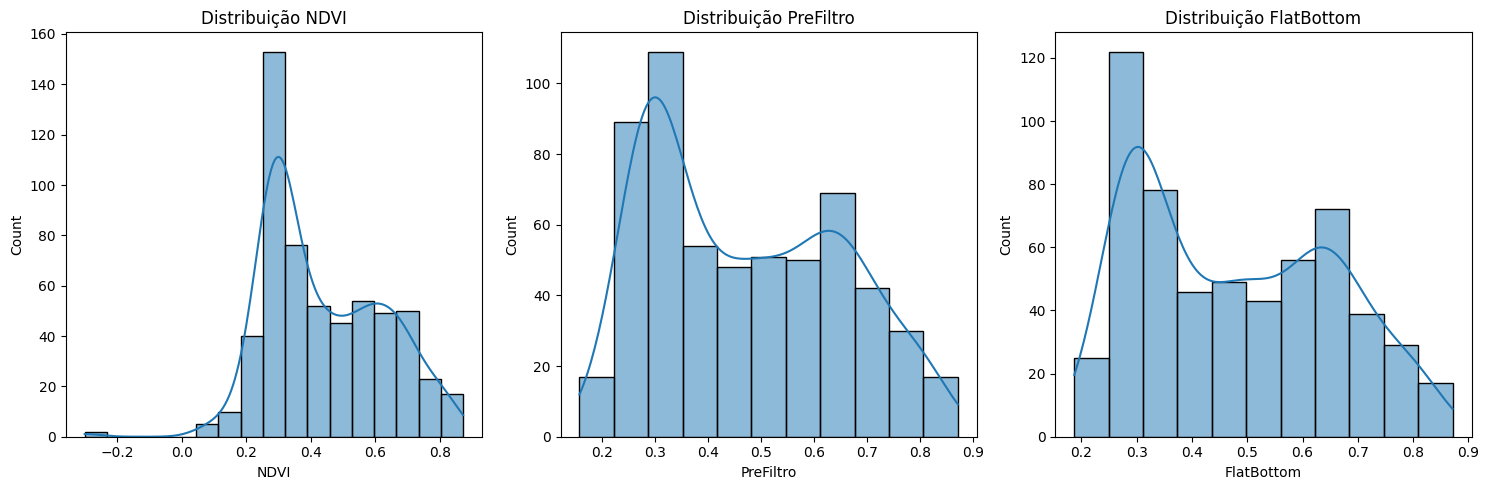

In [ ]:
## 4. Visualização de Dados
print("\n4. Visualização de Dados")

# 4.1 Distribuições (histogramas)
print(" Histograma - Distribuição das variáveis:")
plt.figure(figsize=(15, 5))

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_satveg[coluna], kde=True)
    plt.title(f'Distribuição {coluna}')

plt.tight_layout()
plt.show()


 Evolução temporal das métricas:


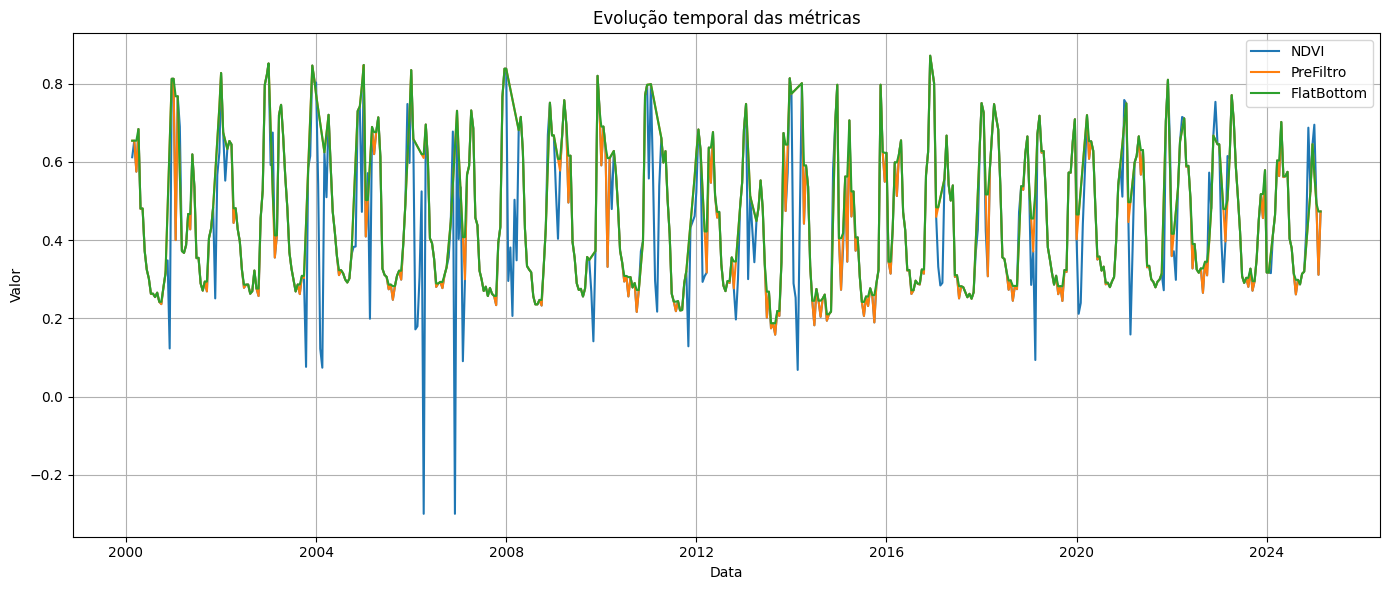

In [ ]:
# 4.2 Séries temporais
print("\n Evolução temporal das métricas:")
plt.figure(figsize=(14, 6))
for coluna in colunas_numericas:
    plt.plot(df_satveg['Data'], df_satveg[coluna], label=coluna)
plt.title('Evolução temporal das métricas')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



 Dispersão - Relações entre variáveis:


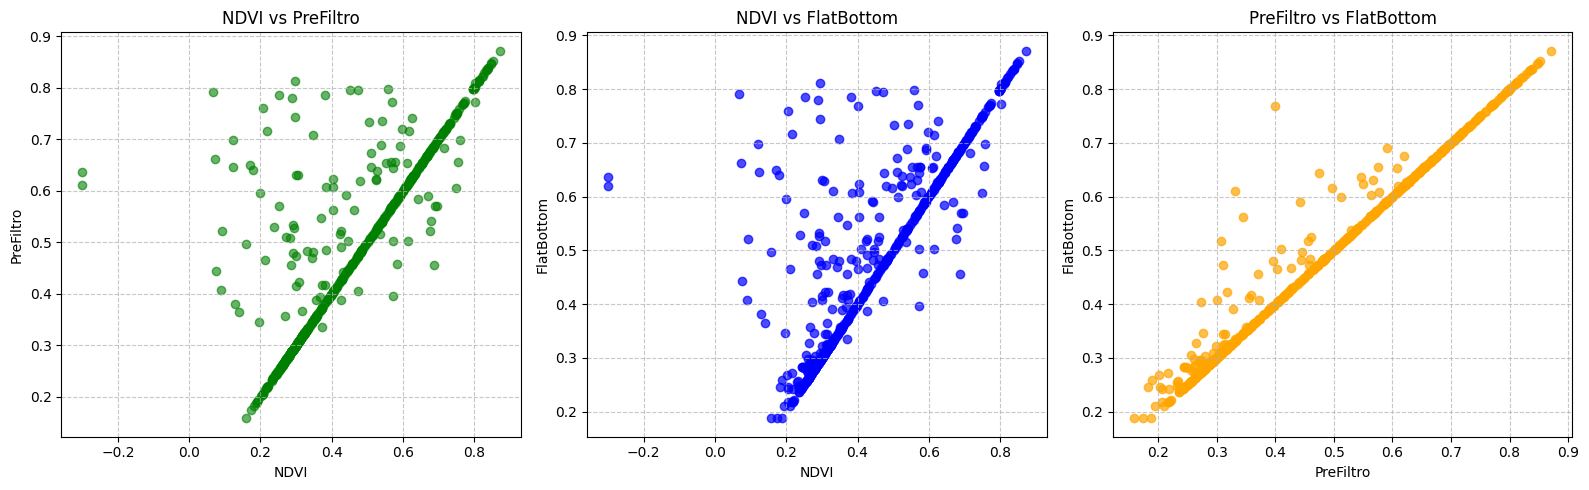

In [ ]:
# 4.3 Relações entre variáveis (dispersão)
print("\n Dispersão - Relações entre variáveis:")
plt.figure(figsize=(16, 5))

# Gráfico 1: NDVI vs PreFiltro
plt.subplot(1, 3, 1)
plt.scatter(df_satveg['NDVI'], df_satveg['PreFiltro'], alpha=0.6, color='green' )
plt.title('NDVI vs PreFiltro')
plt.xlabel('NDVI')
plt.ylabel('PreFiltro')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: NDVI vs FlatBottom
plt.subplot(1, 3, 2)
plt.scatter(df_satveg['NDVI'], df_satveg['FlatBottom'], alpha=0.7, color='blue')
plt.title('NDVI vs FlatBottom')
plt.xlabel('NDVI')
plt.ylabel('FlatBottom')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 3: PreFiltro vs FlatBottom
plt.subplot(1, 3, 3)
plt.scatter(df_satveg['PreFiltro'], df_satveg['FlatBottom'], alpha=0.7, color='orange')
plt.title('PreFiltro vs FlatBottom')
plt.xlabel('PreFiltro')
plt.ylabel('FlatBottom')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


 Boxplots - Comparação de distribuição entre variáveis:


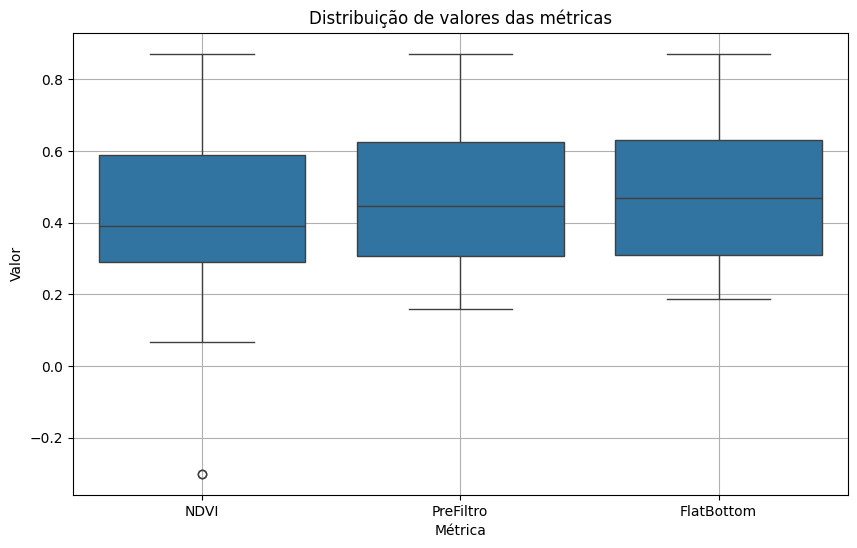

In [ ]:
# 4.4 Comparação de variáveis (boxplots)
print("\n Boxplots - Comparação de distribuição entre variáveis:")
plt.figure(figsize=(10, 6))
df_melt = df_satveg.melt(id_vars='Data', value_vars=colunas_numericas,
                  var_name='Métrica', value_name='Valor')
sns.boxplot(x='Métrica', y='Valor', data=df_melt)
plt.title('Distribuição de valores das métricas')
plt.grid(True)
plt.show()


 Matriz de correlação entre as métricas:


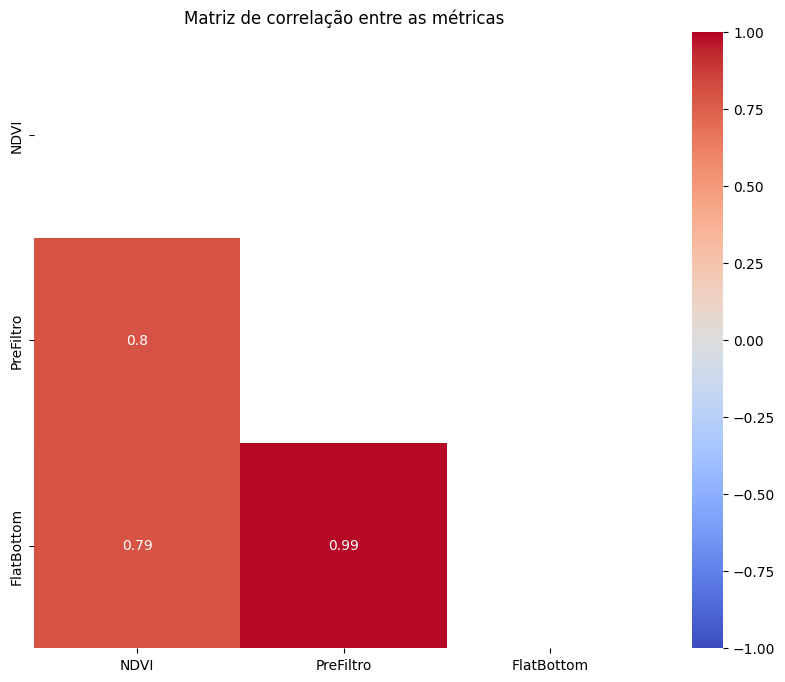

In [ ]:
# 4.5 Matriz de correlação
print("\n Matriz de correlação entre as métricas:")
plt.figure(figsize=(10, 8))
corr = df_satveg[colunas_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de correlação entre as métricas')
plt.show()



In [ ]:
# 4.6 Visualizações interativas com Altair
print("\n Visualização interativa de séries temporais:")

# Criar gráfico interativo para cada métrica
charts = []
for coluna in colunas_numericas:
    chart = alt.Chart(df_satveg).mark_line().encode(
        x='Data',
        y=alt.Y(coluna, title=coluna),
        tooltip=['Data', coluna]
    ).properties(
        title=f'Série Temporal - {coluna}',
        width=300,
        height=200
    )
    charts.append(chart)

# Exibir gráficos em grid
display(alt.vconcat(*charts))



 Visualização interativa de séries temporais:


alt.VConcatChart(...)

In [ ]:
df_satveg.head()

,Data,NDVI,PreFiltro,FlatBottom,NDVI_media_diaria
0,2000-02-18,0.6119,0.6542,0.6542,0.6119
1,2000-03-05,0.6542,0.6542,0.6542,0.6542
2,2000-03-21,0.5751,0.5751,0.6542,0.5751
3,2000-04-06,0.6839,0.6839,0.6839,0.6839
4,2000-04-22,0.4797,0.4797,0.4808,0.4797


In [ ]:
## 5. Exportação/Salvamento dos Dados Processados
print("\n5. Exportação dos Dados Processados")
df_satveg.to_csv('satveg_processado.csv', index=False)
print("- Dados processados salvos como 'satveg_processado.csv'")


5. Exportação dos Dados Processados
- Dados processados salvos como 'satveg_processado.csv'


# Produção Agrícola de grãos

Fonte de dados CONAB, série histórica grãos
https://portaldeinformacoes.conab.gov.br/downloads/arquivos/SerieHistoricaGraos.txt

In [ ]:
# 1. Carregamento importação de dados
print("1. Carregamento dos dados do Produção Agrícola")
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo CSV
filename = list(uploaded.keys())[0]
df_graos = pd.read_csv(filename, encoding='latin1', sep=';')

# Informações básicas
print(f"Arquivo carregado: {filename}")
print(f"Dimensões: {df_graos.shape[0]} linhas x {df_graos.shape[1]} colunas")

1. Carregamento dos dados do Produção Agrícola


Saving serie_historica_graos.csv to serie_historica_graos.csv
Arquivo carregado: serie_historica_graos.csv
Dimensões: 12453 linhas x 8 colunas


In [ ]:
## 2. Pré-processamento

# Visualizar dos dados originais
print("\n=== Primeiras linhas dos dados originais ===")
display(df_graos.head())

print("\n=== Tipos de dados originais ===")
print(df_graos.dtypes)

print("\n=== Lista de colunas originais ===")
print(df_graos.columns.tolist())

# Correção do encoding
print("\n=== CORREÇÃO DE ENCODING ===")
# Salvar uma cópia da coluna com problema para verificação posterior
if 'dsc_safra_previsao' in df_graos.columns:
    print("\nValores únicos antes da correção:")
    print(df_graos['dsc_safra_previsao'].unique())

# Corrigir problemas específicos de encoding
df_graos = df_graos.replace({
    "1Âª SAFRA": "1ª SAFRA",
    "2Âª SAFRA": "2ª SAFRA"
})

# Renomear colunas
print("\n=== RENOMEAÇÃO DE COLUNAS ===")
print("Colunas antes da renomeação:", df_graos.columns.tolist())

df_graos.rename(columns={
    'area_plantada_mil_ha': 'area_plantada',
    'produtividade_mil_ha_mil_t': 'produtividade',
    'producao_mil_t': 'producao',
    'ano_agricola': 'ano'
}, inplace=True)

print("Colunas após renomeação:", df_graos.columns.tolist())

# Filtrar milho em MT
print("\n=== FILTRAGEM PARA MILHO EM MT ===")
print(f"Dados antes da filtragem: {df_graos.shape[0]} linhas x {df_graos.shape[1]} colunas")

# Verificar se a coluna 'produto' existe, senão usar 'dsc_produto'
coluna_produto = 'produto' if 'produto' in df_graos.columns else 'dsc_produto'

df_milho_mt = df_graos[
    (df_graos[coluna_produto].str.contains('MILHO', case=False, na=False)) &
    ((df_graos['uf'] == 'MT') | (df_graos['uf'].str.contains('MT', case=False, na=False)))
]
df_milho_mt = df_milho_mt.reset_index(drop=True)

print(f"Dados após filtragem: {df_milho_mt.shape[0]} linhas x {df_milho_mt.shape[1]} colunas")
print("\nPrimeiras linhas após filtragem:")
display(df_milho_mt.head())

# Extração ano inicial
print("\n=== EXTRAÇÃO DO ANO INICIAL ===")

if 'ano' in df_milho_mt.columns:
    print("\nExemplos de valores da coluna 'ano' antes da extração:")
    display(df_milho_mt['ano'].head())

    # Extrair o ano inicial da safra
    df_milho_mt['ano_inicio'] = df_milho_mt['ano'].str.split('/').str[0].astype(int)

    print("Coluna 'ano_inicio' criada. Primeiros valores:")
    display(df_milho_mt[['ano', 'ano_inicio']].head())
elif 'safra' in df_milho_mt.columns:
    print("\nUsando coluna 'safra' para extração do ano:")
    display(df_milho_mt['safra'].head())

    # Extrair ano da coluna safra
    df_milho_mt['ano_inicio'] = df_milho_mt['safra'].str.extract(r'(\d{4})').astype(int)

    print("Coluna 'ano_inicio' criada. Primeiros valores:")
    display(df_milho_mt[['safra', 'ano_inicio']].head())

# Conversão de tipo de dados
print("\n=== CONVERSÃO DE COLUNAS NUMÉRICAS ===")
# Definir colunas numéricas
colunas_numericas = ['area_plantada', 'produtividade', 'producao']

# Mostrar tipos antes da conversão
print("Tipos de dados antes da conversão:")
for coluna in colunas_numericas:
    if coluna in df_milho_mt.columns:
        print(f"'{coluna}': {df_milho_mt[coluna].dtype}")

# Converter colunas numéricas
for coluna in colunas_numericas:
    if coluna in df_milho_mt.columns:
        if df_milho_mt[coluna].dtype == 'object':
            df_milho_mt[coluna] = df_milho_mt[coluna].str.replace(',', '.').astype(float)
            print(f"Coluna '{coluna}' convertida para numérico")
        else:
            print(f"Coluna '{coluna}' já é do tipo numérico: {df_milho_mt[coluna].dtype}")
    else:
        print(f"Atenção: Coluna '{coluna}' não encontrada no DataFrame")

# Mostrar tipos após conversão
print("\nTipos de dados após conversão:")
for coluna in colunas_numericas:
    if coluna in df_milho_mt.columns:
        print(f"'{coluna}': {df_milho_mt[coluna].dtype}")

# Análise de valores nulos
print("\n=== VALORES NULOS ===")
nulos = df_milho_mt.isnull().sum()
nulos_encontrados = nulos[nulos > 0]

if len(nulos_encontrados) > 0:
    print("Valores nulos encontrados:")
    print(nulos_encontrados)
else:
    print("Não foram encontrados valores nulos nas colunas.")


=== Primeiras linhas dos dados originais ===


,ano_agricola,dsc_safra_previsao,uf,produto,id_produto,area_plantada_mil_ha,producao_mil_t,produtividade_mil_ha_mil_t
0,1976/77,UNICA,AL,ALGODAO EM PLUMA,4586,99.3,6.0,0.1
1,1976/77,UNICA,BA,ALGODAO EM PLUMA,4586,123.4,7.0,0.1
2,1976/77,UNICA,CE,ALGODAO EM PLUMA,4586,1296.0,70.0,0.1
3,1976/77,UNICA,GO,ALGODAO EM PLUMA,4586,73.1,28.2,0.4
4,1976/77,UNICA,MA,ALGODAO EM PLUMA,4586,44.4,2.0,0.0



=== Tipos de dados originais ===
ano_agricola                   object
dsc_safra_previsao             object
uf                             object
produto                        object
id_produto                      int64
area_plantada_mil_ha          float64
producao_mil_t                float64
produtividade_mil_ha_mil_t    float64
dtype: object

=== Lista de colunas originais ===
['ano_agricola', 'dsc_safra_previsao', 'uf', 'produto', 'id_produto', 'area_plantada_mil_ha', 'producao_mil_t', 'produtividade_mil_ha_mil_t']

=== CORREÇÃO DE ENCODING ===

Valores únicos antes da correção:
['UNICA          ' '2Âª SAFRA       ' '1Âª SAFRA       '
 '3Âª SAFRA       ']

=== RENOMEAÇÃO DE COLUNAS ===
Colunas antes da renomeação: ['ano_agricola', 'dsc_safra_previsao', 'uf', 'produto', 'id_produto', 'area_plantada_mil_ha', 'producao_mil_t', 'produtividade_mil_ha_mil_t']
Colunas após renomeação: ['ano', 'dsc_safra_previsao', 'uf', 'produto', 'id_produto', 'area_plantada', 'producao', 'produtivi

,ano,dsc_safra_previsao,uf,produto,id_produto,area_plantada,producao,produtividade
0,1976/77,1Âª SAFRA,MT,MILHO,4742,247.0,385.0,1.6
1,1977/78,1Âª SAFRA,MT,MILHO,4742,179.0,250.0,1.4
2,1978/79,1Âª SAFRA,MT,MILHO,4742,76.0,118.0,1.6
3,1979/80,1Âª SAFRA,MT,MILHO,4742,86.0,143.0,1.7
4,1980/81,1Âª SAFRA,MT,MILHO,4742,110.0,185.0,1.7



=== EXTRAÇÃO DO ANO INICIAL ===

Exemplos de valores da coluna 'ano' antes da extração:


,ano
0,1976/77
1,1977/78
2,1978/79
3,1979/80
4,1980/81


Coluna 'ano_inicio' criada. Primeiros valores:


,ano,ano_inicio
0,1976/77,1976
1,1977/78,1977
2,1978/79,1978
3,1979/80,1979
4,1980/81,1980



=== CONVERSÃO DE COLUNAS NUMÉRICAS ===
Tipos de dados antes da conversão:
'area_plantada': float64
'produtividade': float64
'producao': float64
Coluna 'area_plantada' já é do tipo numérico: float64
Coluna 'produtividade' já é do tipo numérico: float64
Coluna 'producao' já é do tipo numérico: float64

Tipos de dados após conversão:
'area_plantada': float64
'produtividade': float64
'producao': float64

=== VALORES NULOS ===
Não foram encontrados valores nulos nas colunas.


In [ ]:
## 3. Análise Exploratória Básica
print("\n3. Análise Exploratória Básica")
print("- Primeiras linhas dos dados:")
display(df_milho_mt.head())

print("\n- Resumo estatístico das colunas numéricas:")
display(df_milho_mt[colunas_numericas].describe())


3. Análise Exploratória Básica
- Primeiras linhas dos dados:


,ano,dsc_safra_previsao,uf,produto,id_produto,area_plantada,producao,produtividade,ano_inicio
0,1976/77,1Âª SAFRA,MT,MILHO,4742,247.0,385.0,1.6,1976
1,1977/78,1Âª SAFRA,MT,MILHO,4742,179.0,250.0,1.4,1977
2,1978/79,1Âª SAFRA,MT,MILHO,4742,76.0,118.0,1.6,1978
3,1979/80,1Âª SAFRA,MT,MILHO,4742,86.0,143.0,1.7,1979
4,1980/81,1Âª SAFRA,MT,MILHO,4742,110.0,185.0,1.7,1980



- Resumo estatístico das colunas numéricas:


,area_plantada,produtividade,producao
count,89.000000,89.000000,89.000000
mean,1033.767416,3.961798,5700.775281
std,1846.049375,2.315290,11889.778998
min,0.000000,0.000000,0.000000
25%,85.000000,2.100000,385.000000
50%,220.000000,3.700000,698.000000
75%,704.000000,5.900000,2456.000000
max,7367.300000,8.400000,50731.200000



4. Visualização de Dados
 Histograma - Distribuição das variáveis:


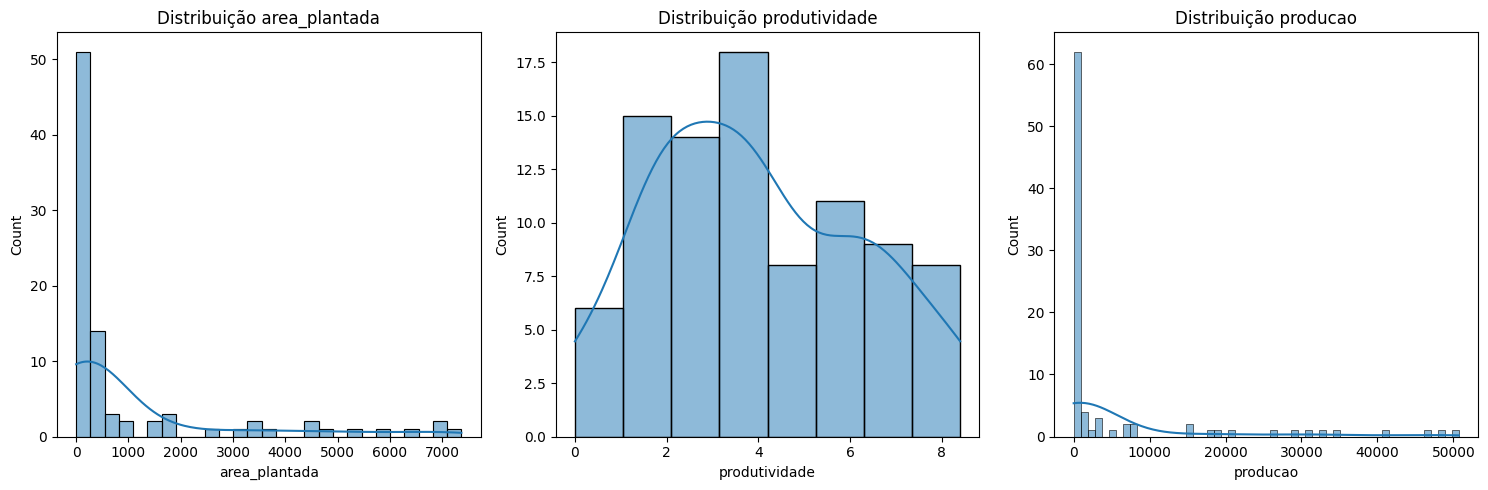

In [ ]:
## 4. Visualização de Dados
print("\n4. Visualização de Dados")

# 4.1 Distribuições (histogramas)
print(" Histograma - Distribuição das variáveis:")
plt.figure(figsize=(15, 5))

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_milho_mt[coluna], kde=True)
    plt.title(f'Distribuição {coluna}')

plt.tight_layout()
plt.show()


 Evolução temporal das métricas:


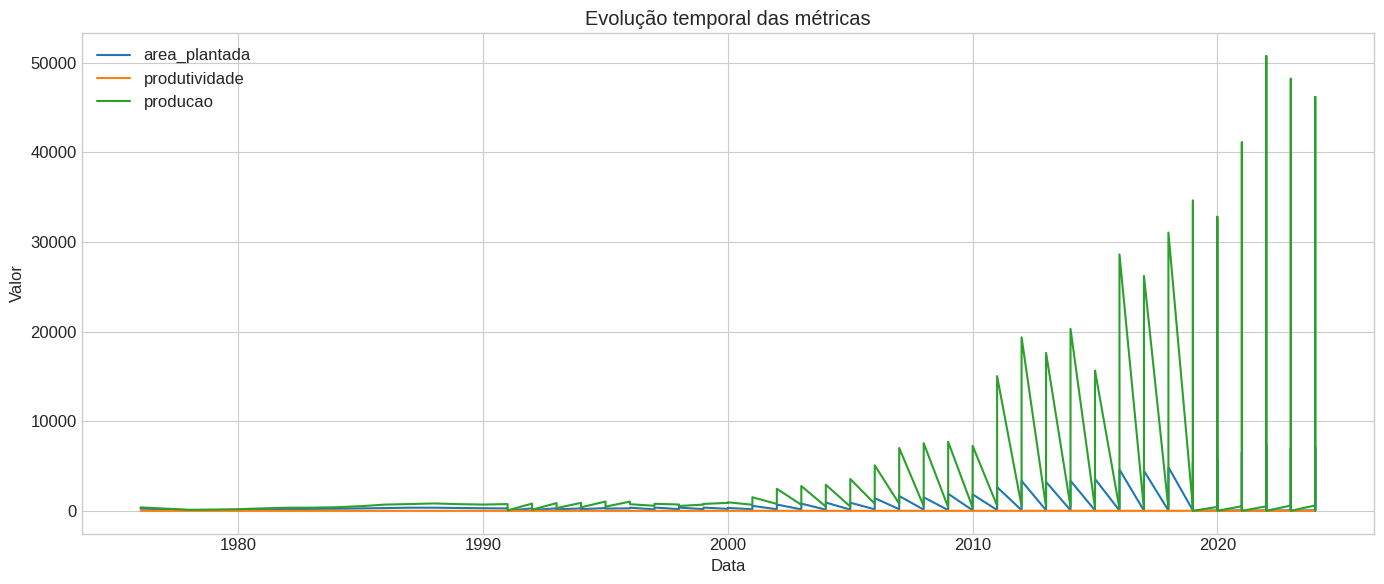

In [ ]:
# 4.2 Séries temporais
print("\n Evolução temporal das métricas:")
plt.figure(figsize=(14, 6))
for coluna in colunas_numericas:
    plt.plot(df_milho_mt['ano_inicio'], df_milho_mt[coluna], label=coluna)
plt.title('Evolução temporal das métricas')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Dispersão - Relações entre variáveis:


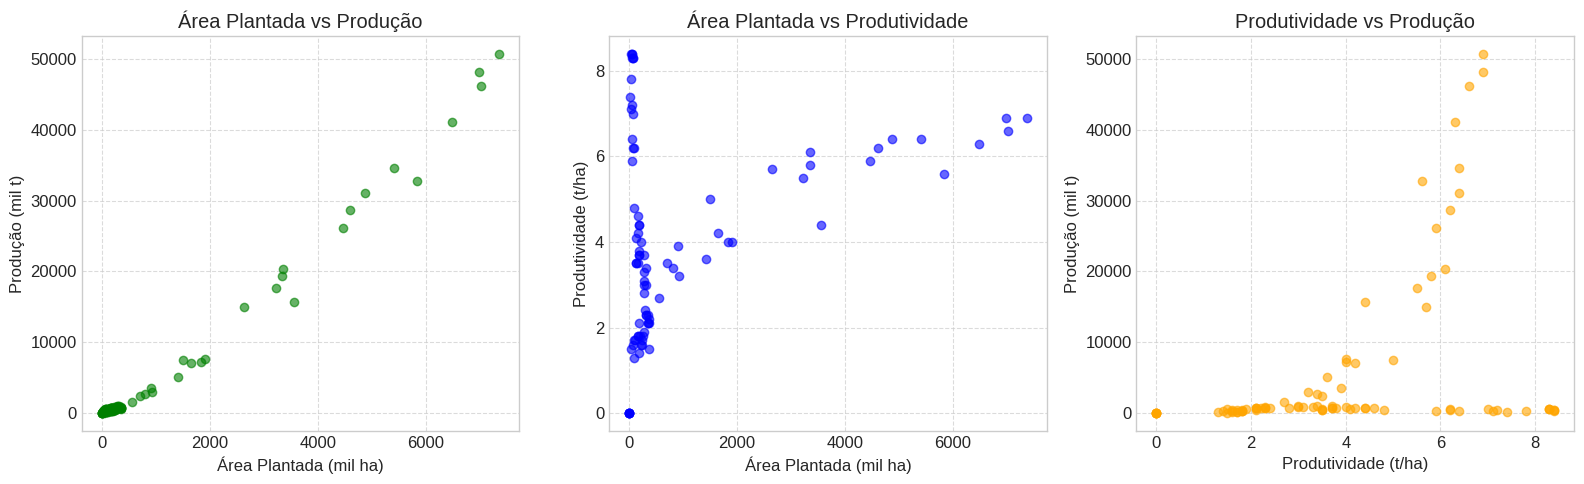

In [ ]:
# 4.3 Relações entre variáveis (dispersão)
print("\n Dispersão - Relações entre variáveis:")
plt.figure(figsize=(16, 5))

# Gráfico 1: Área Plantada vs Produção
plt.subplot(1, 3, 1)
plt.scatter(df_milho_mt['area_plantada'], df_milho_mt['producao'], alpha=0.6, color='green')
plt.title('Área Plantada vs Produção')
plt.xlabel('Área Plantada (mil ha)')
plt.ylabel('Produção (mil t)')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 2: Área Plantada vs Produtividade
plt.subplot(1, 3, 2)
plt.scatter(df_milho_mt['area_plantada'], df_milho_mt['produtividade'], alpha=0.6, color='blue')
plt.title('Área Plantada vs Produtividade')
plt.xlabel('Área Plantada (mil ha)')
plt.ylabel('Produtividade (t/ha)')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico 3: Produtividade vs Produção
plt.subplot(1, 3, 3)
plt.scatter(df_milho_mt['produtividade'], df_milho_mt['producao'], alpha=0.6, color='orange')
plt.title('Produtividade vs Produção')
plt.xlabel('Produtividade (t/ha)')
plt.ylabel('Produção (mil t)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



 Boxplots - Comparação de distribuição entre variáveis (escalas separadas):


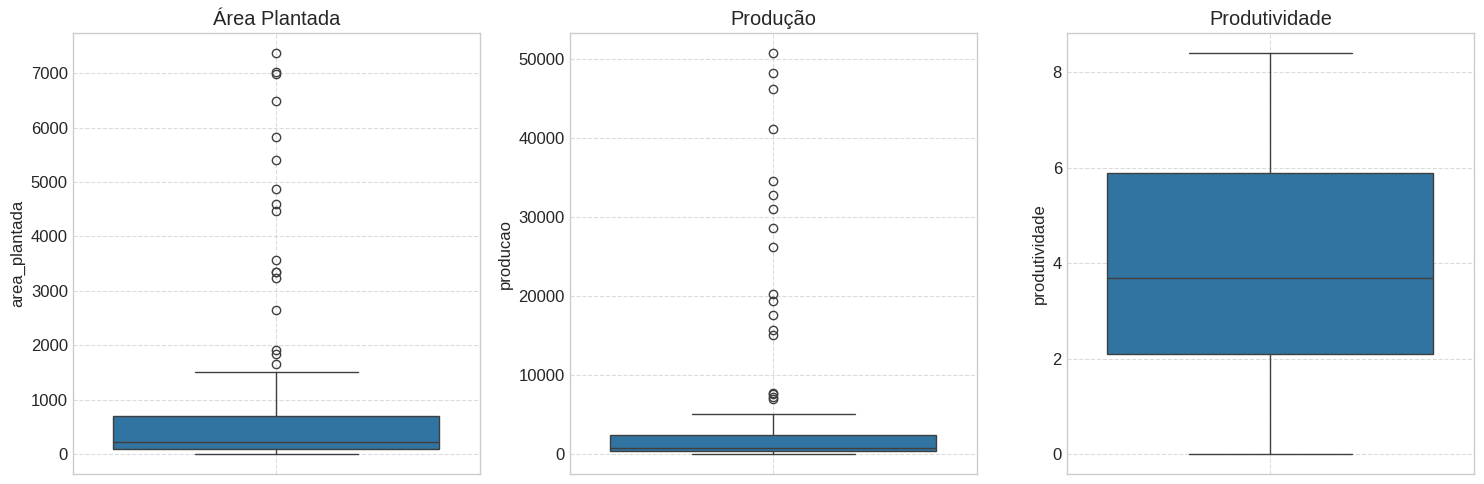


 Boxplots - Distribuição normalizada para comparação entre variáveis:


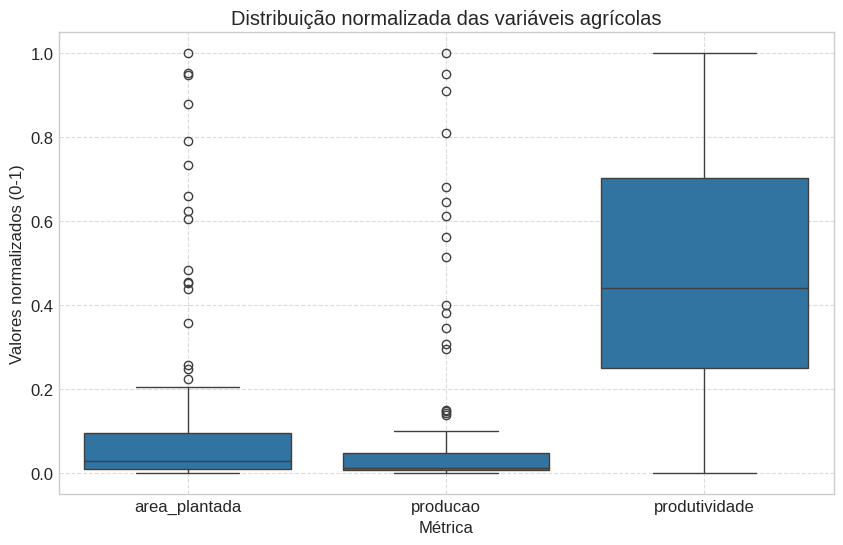

In [ ]:
# 4.4 Comparação de variáveis (boxplots)
# Definir as variáveis numéricas de interesse
colunas_numericas = ['area_plantada', 'producao', 'produtividade']

# Versão 1: Boxplots em escalas separadas
print("\n Boxplots - Comparação de distribuição entre variáveis (escalas separadas):")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_milho_mt['area_plantada'])
plt.title('Área Plantada')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
sns.boxplot(y=df_milho_mt['producao'])
plt.title('Produção')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
sns.boxplot(y=df_milho_mt['produtividade'])
plt.title('Produtividade')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Versão 2: Boxplots normalizados para comparação direta
print("\n Boxplots - Distribuição normalizada para comparação entre variáveis:")
plt.figure(figsize=(10, 6))

# Criar DataFrame para visualização
df_melt = df_milho_mt.melt(id_vars='ano_inicio', value_vars=colunas_numericas,
                  var_name='Métrica', value_name='Valor')

# Adicionar versão normalizada das variáveis
df_norm = df_milho_mt.copy()
for coluna in colunas_numericas:
    df_norm[coluna] = (df_milho_mt[coluna] - df_milho_mt[coluna].min()) / (df_milho_mt[coluna].max() - df_milho_mt[coluna].min())

df_melt_norm = df_norm.melt(id_vars='ano_inicio', value_vars=colunas_numericas,
                  var_name='Métrica', value_name='Valor Normalizado')

sns.boxplot(x='Métrica', y='Valor Normalizado', data=df_melt_norm)
plt.title('Distribuição normalizada das variáveis agrícolas')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Valores normalizados (0-1)')
plt.show()



 Boxplots - Evolução por safra:


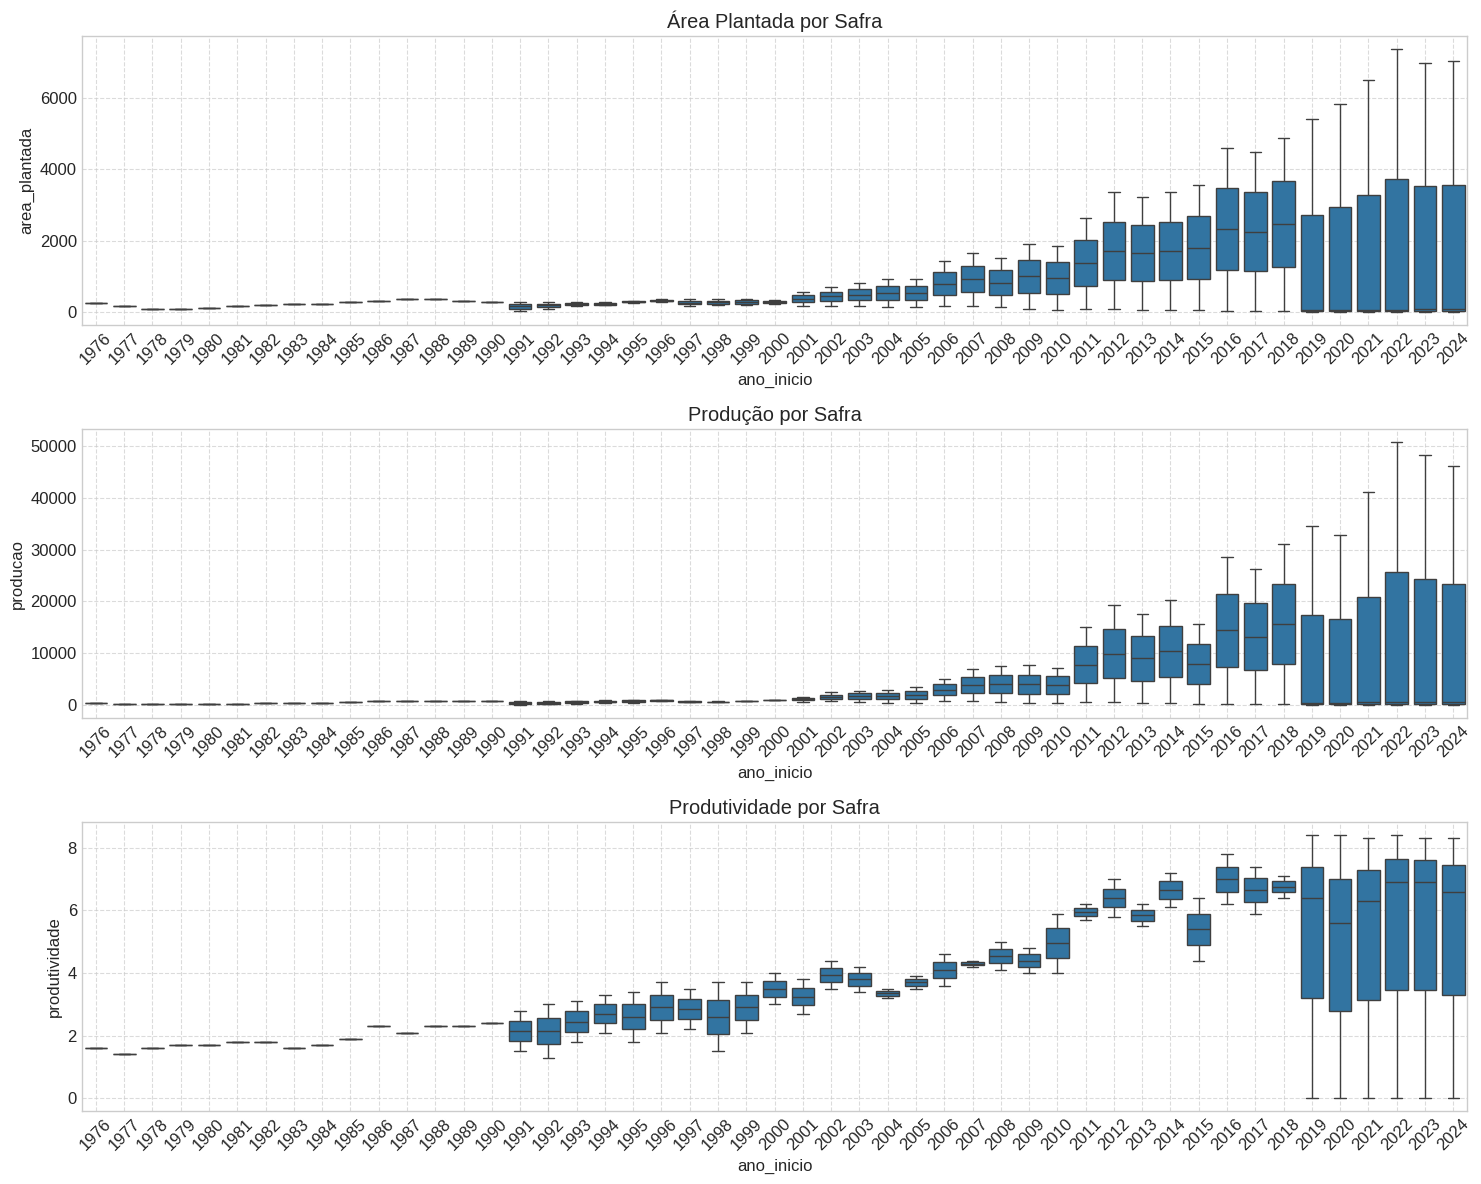

In [ ]:
# Boxplots agrupados por safra
print("\n Boxplots - Evolução por safra:")
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.boxplot(x='ano_inicio', y='area_plantada', data=df_milho_mt)
plt.title('Área Plantada por Safra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.subplot(3, 1, 2)
sns.boxplot(x='ano_inicio', y='producao', data=df_milho_mt)
plt.title('Produção por Safra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.subplot(3, 1, 3)
sns.boxplot(x='ano_inicio', y='produtividade', data=df_milho_mt)
plt.title('Produtividade por Safra')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


 Matriz de correlação entre as métricas:


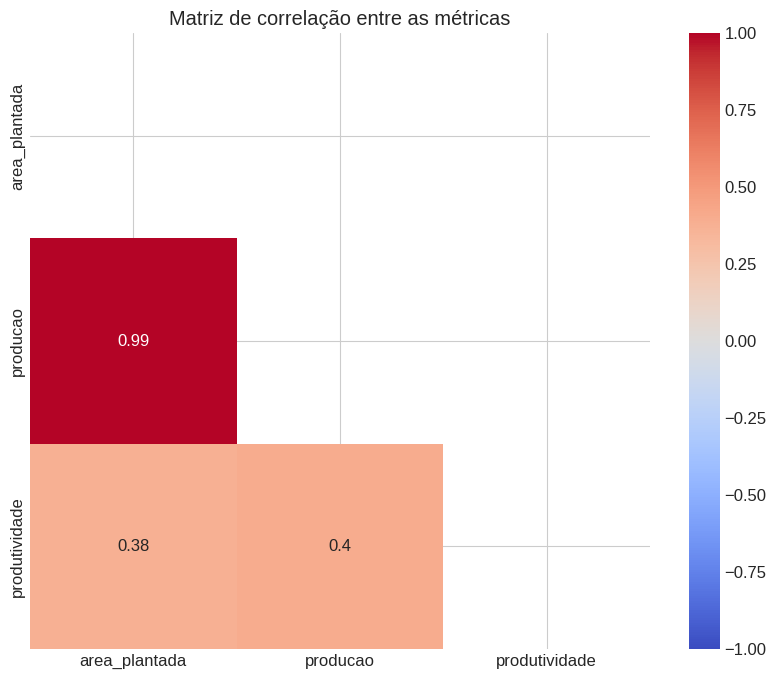

In [ ]:
# 4.5 Matriz de correlação
print("\n Matriz de correlação entre as métricas:")
plt.figure(figsize=(10, 8))
corr = df_milho_mt[colunas_numericas].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de correlação entre as métricas')
plt.show()

In [ ]:
# 4.6 Visualizações interativas com Altair
print("\n Visualização interativa de séries temporais:")

# Criar gráfico interativo para cada métrica
charts = []
for coluna in colunas_numericas:
    chart = alt.Chart(df_milho_mt).mark_line().encode(
        x='ano_inicio',
        y=alt.Y(coluna, title=coluna),
        tooltip=['ano_inicio', coluna]
    ).properties(
        title=f'Série Temporal - {coluna}',
        width=300,
        height=200
    )
    charts.append(chart)

# Exibir gráficos em grid
display(alt.vconcat(*charts))


 Visualização interativa de séries temporais:


alt.VConcatChart(...)

In [ ]:
## 5. Exportação/Salvamento dos Dados Processados
print("\n5. Exportação dos Dados Processados")
df_milho_mt.to_csv('milho_mt_filtrado.csv', index=False)
print("\n Dados filtrados salvos como 'milho_mt_filtrado.csv'")


5. Exportação dos Dados Processados

 Dados filtrados salvos como 'milho_mt_filtrado.csv'


# Dados metereológicos INMET


Optamos por fazer download dos arquivos, pois via API ia ficar muito lento

Fonte de dados https://portal.inmet.gov.br/dadoshistoricos

In [150]:
# 1. Carregamento importação de dados
print("1. Carregamento dos dados meteorológicos INMET")
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo CSV
filename = list(uploaded.keys())[0]
df_clima2023 = pd.read_csv(filename, encoding='latin1', sep=';')

# Informações básicas
print(f"Arquivo carregado: {filename}")
print(f"Dimensões: {df_clima2023 .shape[0]} linhas x {df_clima2023 .shape[1]} colunas")

# 1. Carregamento importação de dados
print("1. Carregamento dos dados meteorológicos INMET")
from google.colab import files
uploaded = files.upload()

1. Carregamento dos dados meteorológicos INMET


Saving Clima_Sorriso_2023.csv to Clima_Sorriso_2023 (10).csv
Arquivo carregado: Clima_Sorriso_2023 (10).csv
Dimensões: 8760 linhas x 19 colunas


In [152]:
# 1. Carregamento importação de dados
print("1. Carregamento dos dados meteorológicos INMET")
from google.colab import files
uploaded = files.upload()

# Carregar o arquivo CSV
filename = list(uploaded.keys())[0]
df_clima2024 = pd.read_csv(filename, encoding='latin1', sep=';')

# Informações básicas
print(f"Arquivo carregado: {filename}")
print(f"Dimensões: {df_clima2024 .shape[0]} linhas x {df_clima2024 .shape[1]} colunas")


1. Carregamento dos dados meteorológicos INMET


Saving Clima_Sorriso_2024.csv to Clima_Sorriso_2024 (10).csv
Arquivo carregado: Clima_Sorriso_2024 (10).csv
Dimensões: 8784 linhas x 19 colunas


In [153]:
import pandas as pd

df1 = pd.read_csv('Clima_Sorriso_2024.csv', encoding='latin1')
df2 = pd.read_csv('Clima_Sorriso_2023.csv', encoding='latin1')

df_clima = pd.concat([df1, df2], ignore_index=True)

print(df_clima.shape)
print(df_clima.head())


ParserError: Error tokenizing data. C error: Expected 11 fields in line 11, saw 12


In [141]:
df_inmet.head()
# Pegando o menor AnoMes em cada base
print('NDVI começa em:', df_inmet['DATA'].min())

print('NDVI termina em:', df_inmet['DATA'].max())


NDVI começa em: 01/01/2024
NDVI termina em: 31/12/2024


In [ ]:
## 5. Exportação/Salvamento dos Dados Processados
print("\n5. Exportação dos Dados Processados")
df_mensal.to_csv('inmet_consolidado_mensal.csv', index=False)
print("\n Dados consolidados 'inmet_consolidado.csv'")

In [ ]:
import pandas as pd

# Leitura inicial sem conversão de tipos
try:
    df_raw = pd.read_csv('clima_Sorriso_2024.csv', dtype=str, encoding='utf-8', delimiter=',') # adapte o encoding/delimiter se necessário
except FileNotFoundError:
    print("Erro: Arquivo 'clima_Sorriso_2024.csv' não encontrado. Verifique se o arquivo está no diretório correto.")
    # Adicione aqui código para lidar com o caso de o arquivo não ser encontrado, por exemplo:
    # df_raw = pd.DataFrame()  # Crie um DataFrame vazio para continuar a execução
    # ou
    # raise  # Para interromper a execução do código

print(df_raw.head(10))
print(df_raw.columns)
print(df_raw.shape)


Erro: Arquivo 'clima_Sorriso_2024.csv' não encontrado. Verifique se o arquivo está no diretório correto.


NameError: name 'df_raw' is not defined

In [ ]:
# Tratamento dos dados
print("\n3. Agregação dos dados: hora para dia (média/soma/máxima)")

# 1. Padronizar nomes (ajuste aqui se seu .csv tiver nomes diferentes)
colunas = {
    'precipitacao': 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
    'pressao': 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'radiacao': 'RADIACAO GLOBAL (Kj/m²)',
    'temperatura_media': 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', # ideal para a analise
    'umidade': 'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'vento_direcao': 'VENTO, DIREÇÃO HORARIA (gr) (° (gr))',
    'vento_rajada': 'VENTO, RAJADA MAXIMA (m/s)',
    'vento_velocidade': 'VENTO, VELOCIDADE HORARIA (m/s)'
}

# 2. DataFrame auxiliar só com as colunas mapeadas, robusto a nomes diferentes de "Data"
df_aux = pd.DataFrame()

# Identificar nome da coluna de data de forma automática
possiveis_nomes_data = [col for col in df_inmet.columns if 'data' in col.lower()]
if len(possiveis_nomes_data):
    nome_col_data = possiveis_nomes_data[0]
    df_aux['data'] = df_inmet[nome_col_data]
    print(f"- Coluna de data identificada: '{nome_col_data}'")
else:
    raise ValueError("Não foi encontrada uma coluna de data no seu DataFrame!")

# Incluir as variáveis de interesse com nomes padronizados
for nome_padrao, nome_arquivo in colunas.items():
    # Busca por nome exato e por aproximação para robustez
    if nome_arquivo in df_inmet.columns:
        df_aux[nome_padrao] = df_inmet[nome_arquivo]
    else:
        # Busca aproximada
        for col in df_inmet.columns:
            if nome_arquivo.split()[0] in col:
                df_aux[nome_padrao] = df_inmet[col]
                print(f"- Mapeada '{col}' para '{nome_padrao}' (correspondência parcial)")

# 3. Limpeza: remover aspas, trocar vírgula por ponto, ajustar valores nulos e forçar float em tudo
for col in df_aux.columns:
    if col == 'data':
        continue  # será tratada depois
    df_aux[col] = (
        df_aux[col]
        .astype(str)
        .str.replace('"','', regex=False)
        .str.replace(',', '.', regex=False)
        .replace(['-9999','nan','None',''], np.nan)
    )
    df_aux[col] = pd.to_numeric(df_aux[col], errors='coerce')

# 4. Converter coluna 'data' para datetime (e manter só a data, sem hora)
df_aux['data'] = pd.to_datetime(df_aux['data'], errors='coerce').dt.date

# 5. Remover linhas totalmente vazias (sem dados úteis)
antes = len(df_aux)
df_aux = df_aux.dropna(how='all', subset=list(colunas.keys()))
print(f"- Linhas totalmente vazias removidas: {antes-len(df_aux)}")

# 6. Crie dicionário de agregação
agregacoes = {
    'precipitacao': 'sum',
    'pressao': 'mean',
    'radiacao': 'mean',
    'temperatura_media': 'mean',
    'umidade': 'mean',
    'vento_direcao': 'mean',
    'vento_rajada': 'max',
    'vento_velocidade': 'mean'
}
# Só inclui agregações de colunas realmente existentes
agregacoes = {k: v for k, v in agregacoes.items() if k in df_aux.columns}

# 7. Realize o agrupamento por dia
df_diario = df_aux.groupby('data').agg(agregacoes).reset_index()

# 8. Mostre resultado
print("\nPrimeiras linhas do DataFrame diário:\n")
print(df_diario.head())
print(f"\n- Total de dias agregados: {df_diario.shape[0]}\n")



3. Agregação dos dados: hora para dia (média/soma/máxima)
- Coluna de data identificada: 'DATA'
- Linhas totalmente vazias removidas: 30506

Primeiras linhas do DataFrame diário:

         data  precipitacao     pressao  radiacao  temperatura_media  \
0  2005-01-01           0.0  968.675000       NaN          25.208333   
1  2005-01-02           0.0  965.258333       NaN          24.104167   
2  2005-01-03           0.0  968.591667       NaN          26.091667   
3  2005-01-04           0.0  968.479167       NaN          25.537500   
4  2005-01-05           0.0  971.975000       NaN          23.683333   

     umidade  vento_direcao  vento_rajada  vento_velocidade  
0  82.875000     175.708333           0.0               0.0  
1  85.833333     163.291667           0.0               0.0  
2  81.833333     179.750000           0.0               0.0  
3  83.375000     129.416667           0.1               0.0  
4  75.333333     166.541667           0.0               0.0  

- Total de di

In [ ]:
pd.set_option('display.max_rows', len(df_diario))

# Ajuste a visualização para o número de linhas da base clima
pd.set_option('display.max_rows', len(df_clima))

# Agora, ao imprimir, verá todas as linhas
print(df_clima)
pd.set_option('display.max_rows', len(df_clima))

# Agora, ao imprimir, verá todas as linhas
print(df_clima)

     ano_mes  precipitacao     pressao     radiacao  temperatura_media  \
0    2005-01      0.000000  969.251610          NaN          25.342140   
1    2005-01      0.000000  969.419491          NaN          24.749277   
2    2005-01      0.000000  969.302812          NaN          25.653923   
3    2005-01      0.000000  969.107860          NaN          26.296149   
4    2005-01      0.033333  969.260524          NaN          26.195120   
5    2005-01      0.000000  969.389591          NaN          25.775879   
6    2005-01      0.000000  969.109254          NaN          25.589387   
7    2005-01      0.000000  969.186585          NaN          25.550248   
8    2005-01      0.000000  969.485417          NaN          25.365278   
9    2005-01      0.000000  968.832180          NaN          25.513921   
10   2005-01      0.000000  968.671548          NaN          25.744399   
11   2005-01      0.000000  968.702170          NaN          25.473449   
12   2005-02      5.900000  969.166345

In [ ]:
# 3. Análise Exploratória Básica
print("\n3. Análise Exploratória Básica")
print("- Primeiras linhas dos dados:")
display(df_diario.head())

print("\n- Resumo estatístico das colunas numéricas:")
display(df_diario[['umidade','vento_direcao']].describe())


3. Análise Exploratória Básica
- Primeiras linhas dos dados:


,data,precipitacao,pressao,radiacao,temperatura_media,umidade,vento_direcao,vento_rajada,vento_velocidade
0,2005-01-01,0.0,968.675000,NaN,25.208333,82.875000,175.708333,0.0,0.0
1,2005-01-02,0.0,965.258333,NaN,24.104167,85.833333,163.291667,0.0,0.0
2,2005-01-03,0.0,968.591667,NaN,26.091667,81.833333,179.750000,0.0,0.0
3,2005-01-04,0.0,968.479167,NaN,25.537500,83.375000,129.416667,0.1,0.0
4,2005-01-05,0.0,971.975000,NaN,23.683333,75.333333,166.541667,0.0,0.0



- Resumo estatístico das colunas numéricas:


,umidade,vento_direcao
count,1141.000000,1141.000000
mean,-298.501375,-337.656597
std,1566.512338,1931.120185
min,-9999.000000,-9999.000000
25%,49.250000,98.833333
50%,68.541667,152.708333
75%,79.250000,199.750000
max,94.000000,313.791667


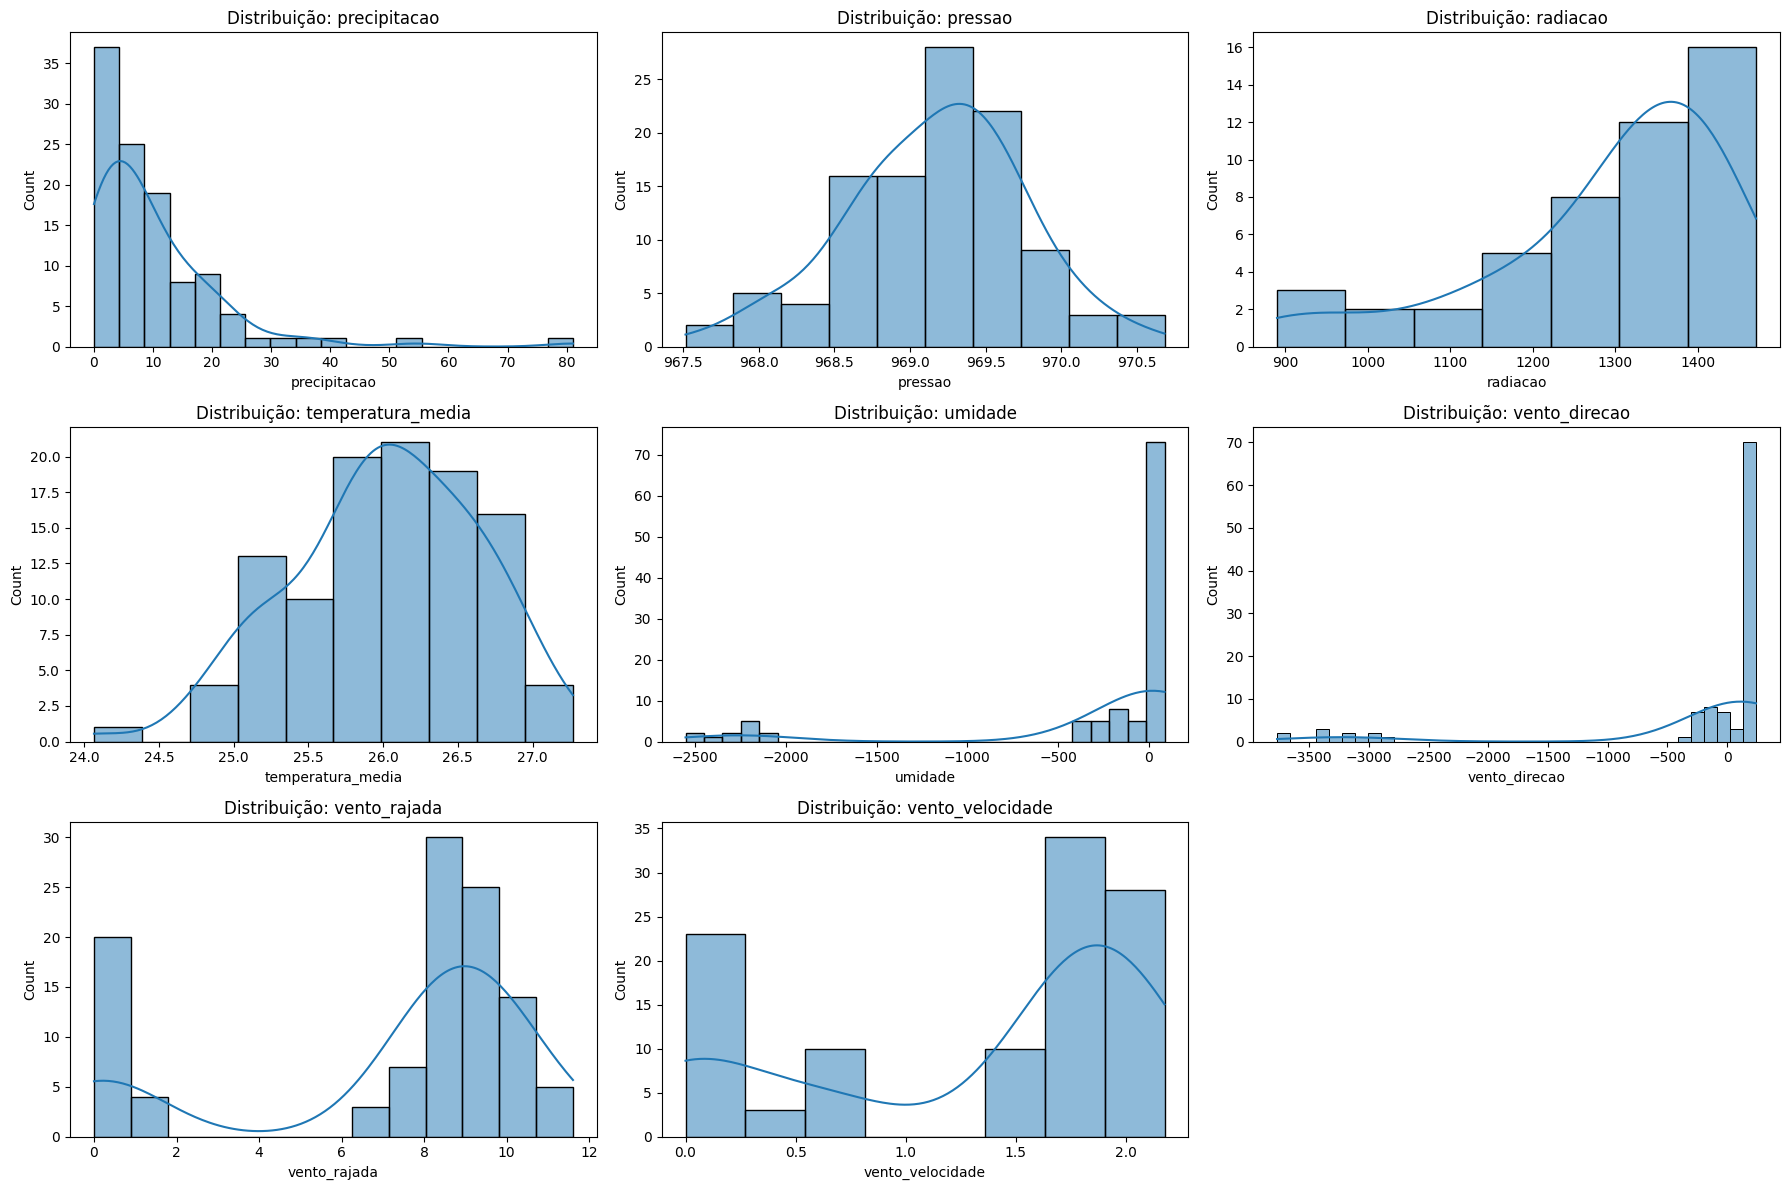

In [ ]:
# 4.1 Distribuições (histogramas)

colunas_numericas = df_diario.select_dtypes(include=[np.number]).columns.tolist()

# Monta os subplots conforme o número de variáveis
num_cols = 3
num_vars = len(colunas_numericas)
num_rows = int(np.ceil(num_vars / num_cols))

plt.figure(figsize=(6*num_cols, 4*num_rows))

for i, coluna in enumerate(colunas_numericas):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(df_mensal[coluna], kde=True)
    plt.title(f'Distribuição: {coluna}')

plt.tight_layout()
plt.show()



Evolução temporal das métricas:


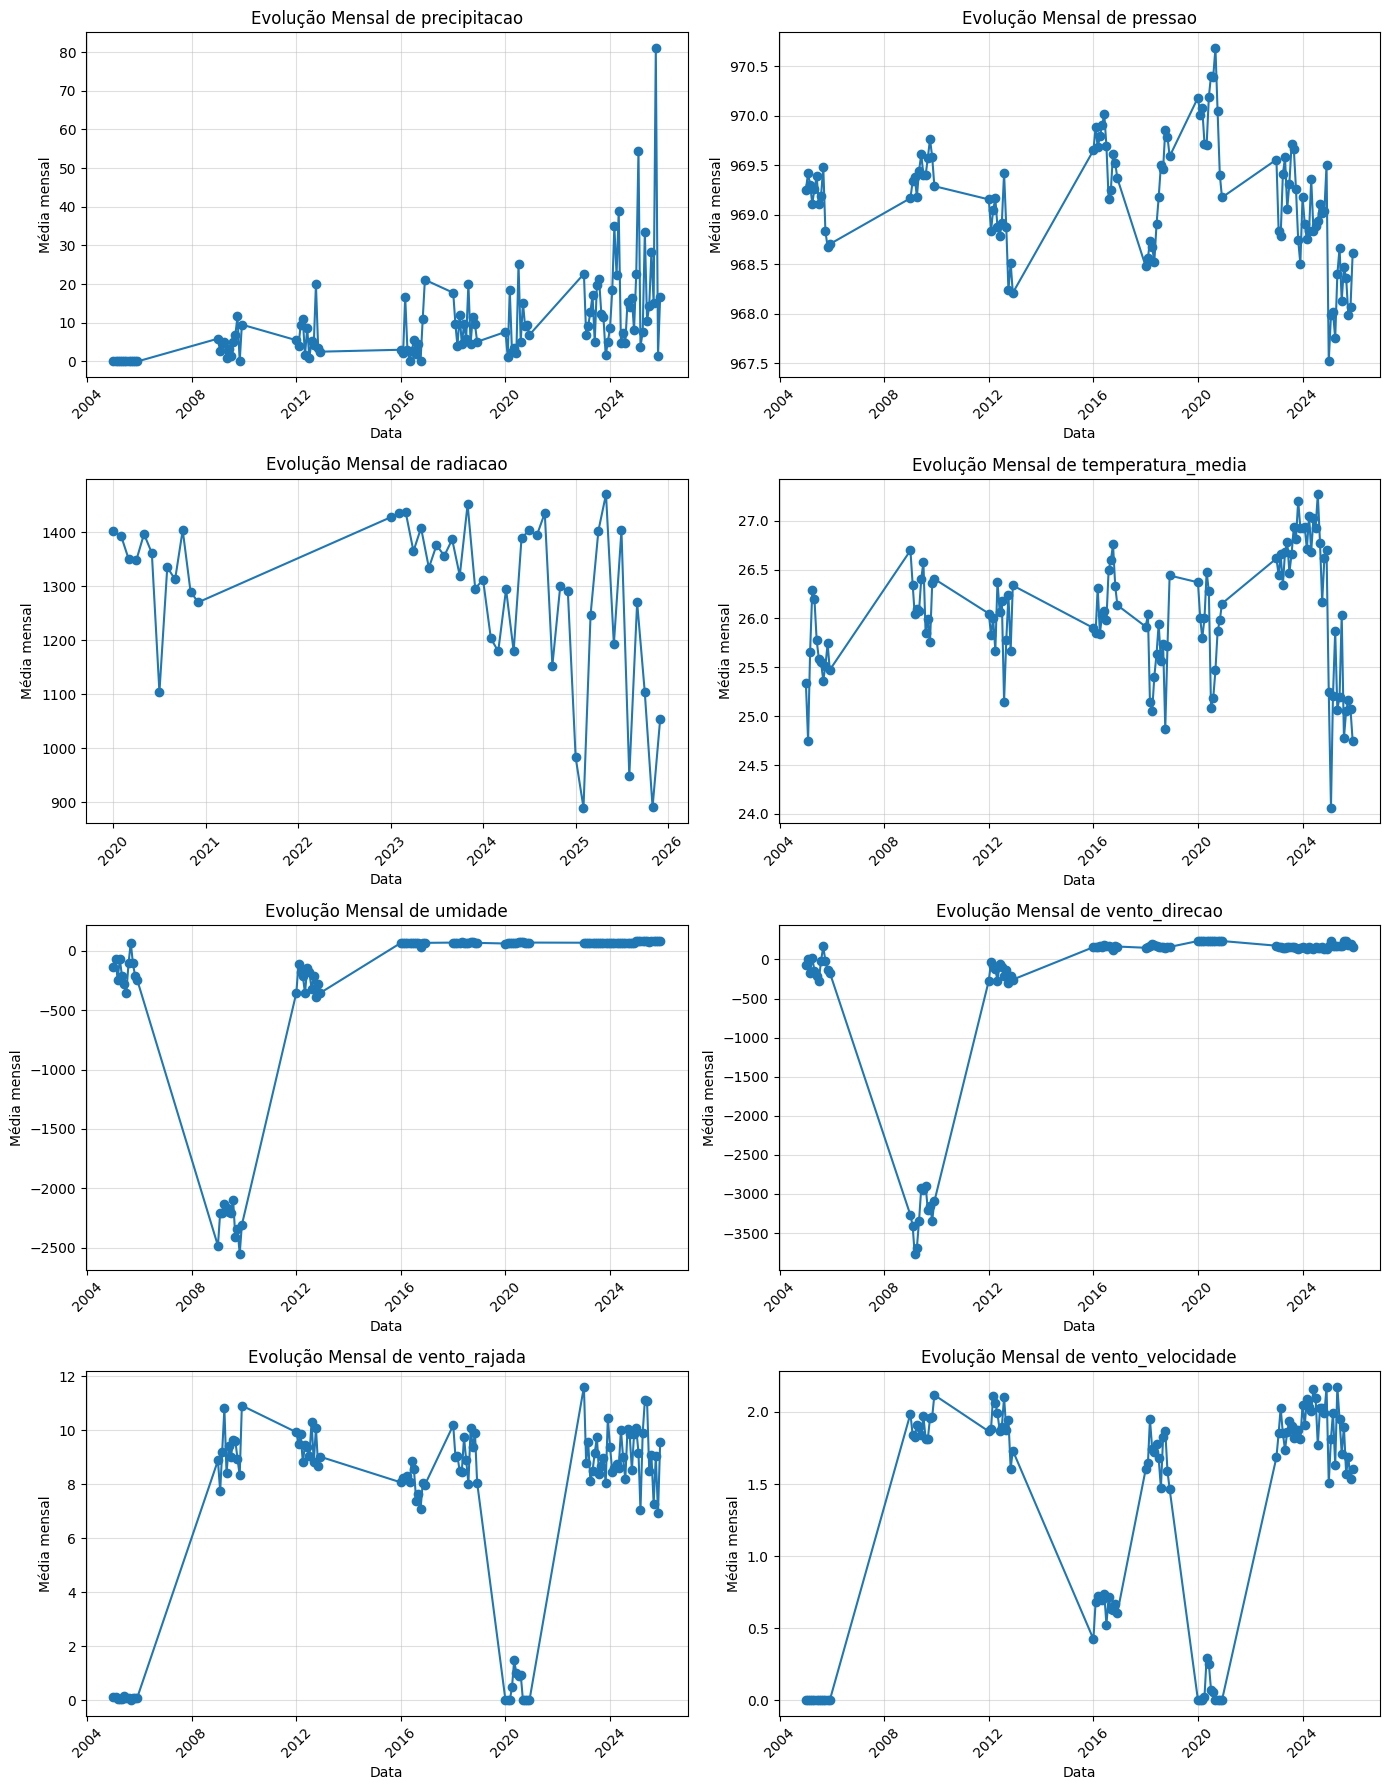

In [ ]:
# 4.2 Séries temporais
print("\nEvolução temporal das métricas:")

# Agrupar por mês e calcular a média
df_mensal = df_diario.groupby('ano_mes')[colunas_numericas].mean().reset_index()
df_mensal['data'] = pd.to_datetime(df_mensal['ano_mes'] + '-01')

# Plot evolutivo
num_vars = len(colunas_numericas)
num_cols = 2
num_rows = int(np.ceil(num_vars / num_cols))

plt.figure(figsize=(7*num_cols, 4.5*num_rows))
for i, coluna in enumerate(colunas_numericas):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(df_mensal['data'], df_mensal[coluna], marker='o', linestyle='-')
    plt.title(f'Evolução Mensal de {coluna}')
    plt.xlabel('Data')
    plt.ylabel('Média mensal')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()



In [ ]:
# 4.3 Relações entre variáveis meteorológicas (dispersão)
import pandas as pd
import numpy as np

# 1. Converter data para datetime (garantia)
df_mensal['data'] = pd.to_datetime(df_diario['data'], errors='coerce')

# 2. Criar coluna ano_mes
df_mensal['ano_mes'] = df_diario['data'].dt.to_period('M').astype(str)

# 3. Selecionar colunas numéricas
colunas_numericas = df_mensal.select_dtypes(include=[np.number]).columns.tolist()

# 4. Cálculo das métricas de dispersão mensais
df_disp = df_mensal.groupby('ano_mes')[colunas_numericas].agg(['std', 'min', 'max', 'mean'])

# 5. Organizar multi-index
df_disp.columns = ['_'.join(col).strip() for col in df_disp.columns.values]
df_disp = df_disp.reset_index()
df_disp['data'] = pd.to_datetime(df_disp['ano_mes'] + '-01')

# 6. Coeficiente de variação (CV = std / mean)
for col in colunas_numericas:
    std_col = f'{col}_std'
    mean_col = f'{col}_mean'
    cv_col = f'{col}_cv'
    df_disp[cv_col] = df_disp[std_col] / df_disp[mean_col]

# 7. Visualizar as métricas calculadas
print("Métricas de dispersão mensais:")
print(df_disp[[c for c in df_disp.columns if any(x in c for x in ['std','cv','min','max']) or c=='ano_mes']].head())




Métricas de dispersão mensais:
   ano_mes  precipitacao_std  precipitacao_min  precipitacao_max  pressao_std  \
0  2005-01          0.009623          0.000000          0.033333     0.273551   
1  2005-02          3.457608          0.000000         11.633333     0.178817   
2  2005-03          5.308043          0.966667         20.066667     0.364949   
3  2005-04          6.763307          0.000000         21.133333     0.264827   
4  2005-05          5.238115          3.966667         20.066667     0.517153   

   pressao_min  pressao_max  radiacao_std  radiacao_min  radiacao_max  ...  \
0   968.671548   969.485417           NaN           NaN           NaN  ...   
1   969.166345   969.762999           NaN           NaN           NaN  ...   
2   968.209158   969.423638           NaN           NaN           NaN  ...   
3   969.153819   970.014931           NaN           NaN           NaN  ...   
4   968.476389   969.853819           NaN           NaN           NaN  ...   

   vento_velo

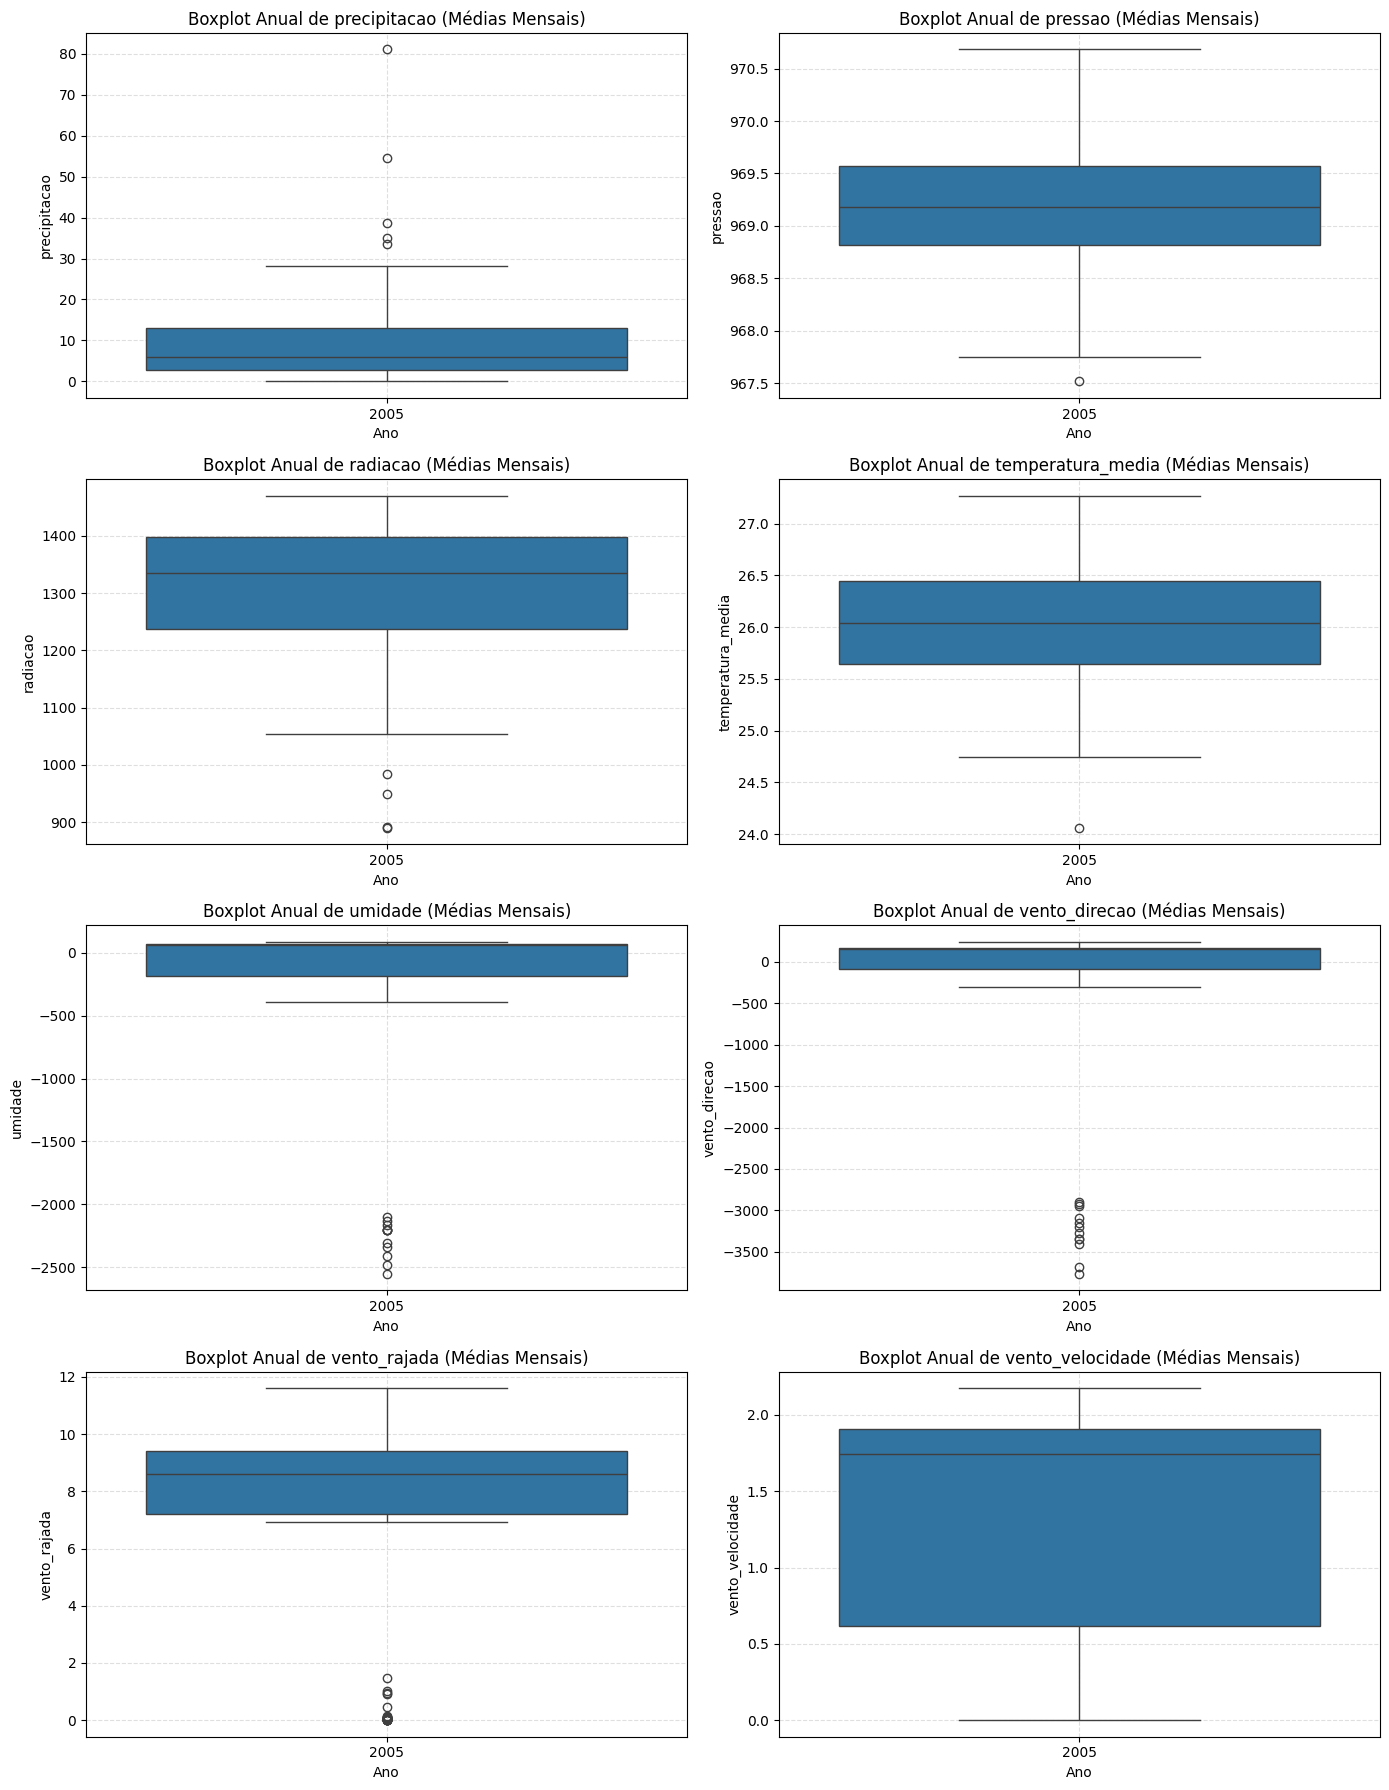

In [ ]:
# 4.4 Relações entre variáveis meteorológicas (boxplot)

# Garante formato certo da data (no df_mensal)
df_mensal['data'] = pd.to_datetime(df_mensal['data'], errors='coerce')
df_mensal['ano'] = df_mensal['data'].dt.year.astype(str)

# Seleciona colunas numéricas do df_mensal
colunas_numericas = df_mensal.select_dtypes(include=[np.number]).columns.tolist()

num_vars = len(colunas_numericas)
num_cols = 2
num_rows = int(np.ceil(num_vars / num_cols))

plt.figure(figsize=(7*num_cols, 4.5*num_rows))
for i, coluna in enumerate(colunas_numericas):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(x='ano', y=coluna, data=df_mensal)
    plt.title(f'Boxplot Anual de {coluna} (Médias Mensais)')
    plt.xlabel('Ano')
    plt.ylabel(coluna)
    plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



 Matriz de correlação entre variáveis meteorológicas:
Matriz de Correlação:
                   precipitacao   pressao  radiacao  temperatura_media  \
precipitacao           1.000000 -0.262316 -0.449929          -0.178708   
pressao               -0.262316  1.000000  0.403996           0.169111   
radiacao              -0.449929  0.403996  1.000000           0.625640   
temperatura_media     -0.178708  0.169111  0.625640           1.000000   
umidade                0.201402 -0.126866 -0.637064          -0.100707   
vento_direcao          0.189888 -0.122164 -0.175185          -0.108131   
vento_rajada           0.273387 -0.367499 -0.119221           0.211238   
vento_velocidade       0.285637 -0.442233 -0.090178           0.226944   

                    umidade  vento_direcao  vento_rajada  vento_velocidade  
precipitacao       0.201402       0.189888      0.273387          0.285637  
pressao           -0.126866      -0.122164     -0.367499         -0.442233  
radiacao          -0.6370

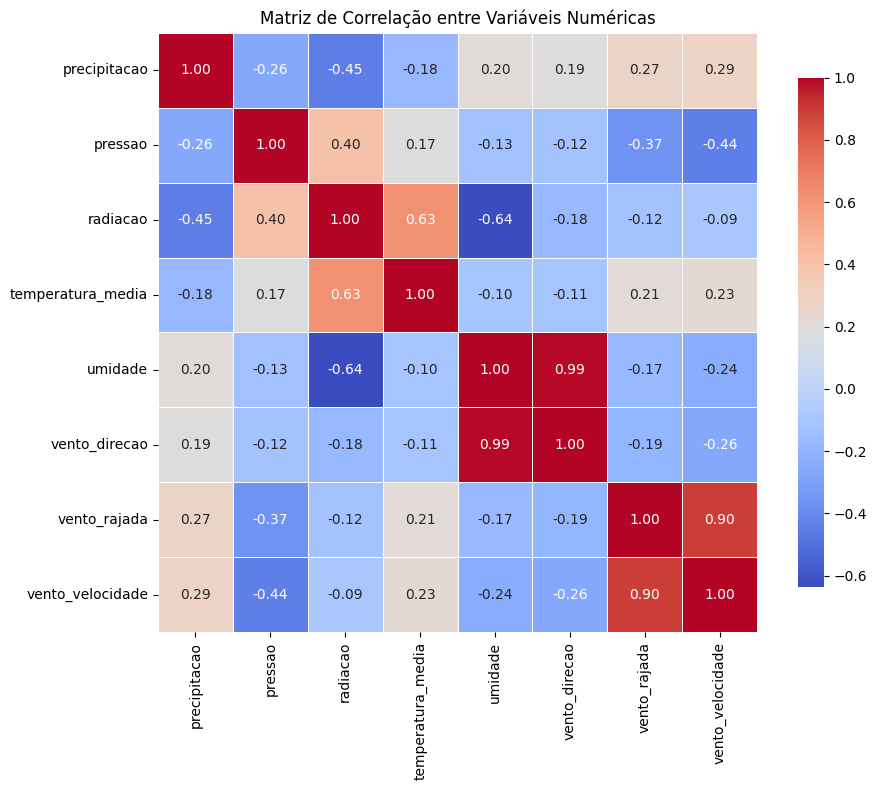

In [ ]:
# 4.5 Matriz de correlação entre variáveis meteorológicas
print("\n Matriz de correlação entre variáveis meteorológicas:")


colunas_numericas = df_mensal.select_dtypes(include=[np.number]).columns.tolist()

# Calcular a matriz de correlação
correlacao = df_mensal[colunas_numericas].corr()

print("Matriz de Correlação:")
print(correlacao)

plt.figure(figsize=(10,8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.85})
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()





In [ ]:
## 5. Exportação/Salvamento dos Dados Processados
print("\n5. Exportação dos Dados Processados")
df_mensal.to_csv('inmet_consolidado_mensal.csv', index=False)
print("\n Dados consolidados 'inmet_consolidado.csv'")


5. Exportação dos Dados Processados

 Dados consolidados 'inmet_consolidado.csv'


# Etapa 2 – Extração de Informações Relevantes:

*   Definir variáveis-chave a serem utilizadas no modelo, a partir da análise
exploratória dos dados.
*   Analisar a relação entre NDVI e produtividade agrícola, identificando os períodos críticos de crescimento da cultura.
*   Aplicar técnicas de segmentação para destacar áreas específicas de cultivo na imagem de satélite.

Definir variáveis-chave a serem utilizadas no modelo, a partir da análise exploratória dos dados.


1.   Vegetação (SatVeg)	NDVI	Preditividade, vigor da cultura
2.   Meteorologia	Precipitação acumulada	Impacto direto no rendimento
3.   Meteorologia	Temperatura média	Influência no ciclo de crescimento
4.   Agrícola	Produtividade	Alvo a ser predito (t/ha)
5.   Temporal	Ano-início/Safra	Capitula avanço tecnológico/clima


In [ ]:
df = pd.read_csv('satveg_processado.csv')
print("Arquivo CSV carregado com sucesso!")
print(df.head()) # Exibe as primeiras linhas do DataFrame

print("Tipos de dados de cada coluna:")
print(df.dtypes)


Arquivo CSV carregado com sucesso!
         Data    NDVI  PreFiltro  FlatBottom  NDVI_media_diaria   AnoMes  \
0  2000-02-18  0.6119     0.6542      0.6542             0.6119  2000-02   
1  2000-03-05  0.6542     0.6542      0.6542             0.6542  2000-03   
2  2000-03-21  0.5751     0.5751      0.6542             0.5751  2000-03   
3  2000-04-06  0.6839     0.6839      0.6839             0.6839  2000-04   
4  2000-04-22  0.4797     0.4797      0.4808             0.4797  2000-04   

   NDVI_media_mensal  
0            0.61190  
1            0.61465  
2            0.61465  
3            0.58180  
4            0.58180  
Tipos de dados de cada coluna:
Data                  object
NDVI                 float64
PreFiltro            float64
FlatBottom           float64
NDVI_media_diaria    float64
AnoMes                object
NDVI_media_mensal    float64
dtype: object


In [ ]:
# Converter a coluna 'Data' para o tipo datetime
df['Data'] = pd.to_datetime(df['Data'])

# Selecionar apenas as colunas 'Data' e 'NDVI'
df_selecionado = df[['AnoMes','NDVI_media_mensal']].copy()

# Exibir o tipo de dados atualizado da coluna 'Data'
print("Tipos de dados após a conversão:")
print(df_selecionado.dtypes)

# Exibir as primeiras linhas do DataFrame resultante
print("\nDataFrame com apenas 'AnoMes' e 'NDVI_media_mensal':")
print(df_selecionado.head())

Tipos de dados após a conversão:
AnoMes                object
NDVI_media_mensal    float64
dtype: object

DataFrame com apenas 'AnoMes' e 'NDVI_media_mensal':
    AnoMes  NDVI_media_mensal
0  2000-02            0.61190
1  2000-03            0.61465
2  2000-03            0.61465
3  2000-04            0.58180
4  2000-04            0.58180


In [ ]:
## 5. Exportação/Salvamento dos Dados Processados
print("\n5. Exportação dos Dados Processados")
df_selecionado.to_csv('ndvi_mensal.csv', index=False)
print("\n Arquivo salvo 'inmet_consolidado.csv'")


5. Exportação dos Dados Processados

 Arquivo salvo 'inmet_consolidado.csv'


In [ ]:
df = pd.read_csv('milho_mt_filtrado.csv')
print("Arquivo CSV carregado com sucesso!")
print(df.head()) # Exibe as primeiras linhas do DataFrame

print("Tipos de dados de cada coluna:")
print(df.dtypes)

Arquivo CSV carregado com sucesso!
                    ano dsc_safra_previsao  uf  \
0  1976/77                1Âª SAFRA         MT   
1  1977/78                1Âª SAFRA         MT   
2  1978/79                1Âª SAFRA         MT   
3  1979/80                1Âª SAFRA         MT   
4  1980/81                1Âª SAFRA         MT   

                                    produto  id_produto  area_plantada  \
0  MILHO                                           4742          247.0   
1  MILHO                                           4742          179.0   
2  MILHO                                           4742           76.0   
3  MILHO                                           4742           86.0   
4  MILHO                                           4742          110.0   

   producao  produtividade  ano_inicio  
0     385.0            1.6        1976  
1     250.0            1.4        1977  
2     118.0            1.6        1978  
3     143.0            1.7        1979  
4     185.0   

In [ ]:
import pandas as pd
import re

df = pd.read_csv('milho_mt_filtrado.csv')

# Ajusta nome correto da coluna de safra (procura o nome real):
col_ano = 'ano'
col_safra_original = None
for nome in df.columns:
    if 'safra' in nome and 'previsao' in nome:
        col_safra_original = nome
        break
if col_safra_original is None:
    raise Exception('Coluna com "safra" e "previsao" não localizada.')

# Limpa a coluna de safra original, padronizando para maiúsculo, sem 'Â', sem espaços
df[col_safra_original] = df[col_safra_original].str.replace('Â', '', regex=False).str.strip().str.upper()

# **Filtra/remova as linhas da 3ª SAFRA**
#     - Remove 'ª' e espaços, compara com "3SAFRA"
mascara_3safra = df[col_safra_original].str.replace('ª', '', regex=False)
mascara_3safra = mascara_3safra.str.replace(' ', '', regex=False)
df = df[~(mascara_3safra == '3SAFRA')].copy()

def calcula_anomes(row):
    # Extrai os quatro primeiros dígitos do ano
    ano_str = str(row[col_ano])
    match = re.match(r'(\d{4})', ano_str)
    if match:
        ano = match.group(1)
    else:
        return pd.NA
    # Remove 'ª' e espaços da safra
    safra = str(row[col_safra_original]).replace('ª', '')
    safra = ''.join(safra.split())
    if safra == '1SAFRA':
        mes = '09'
    elif safra == '2SAFRA':
        mes = '01'
    else:
        return pd.NA
    return f'{ano}-{mes}'

df['AnoMes'] = df.apply(calcula_anomes, axis=1)

# Agora crie uma nova coluna 'safra' limpa, baseada na coluna original já tratada
df['safra'] = df[col_safra_original]

colunas_exibir = ['AnoMes', 'safra', 'area_plantada', 'producao', 'produtividade']
for col in colunas_exibir:
    if col not in df.columns:
        print(f'ATENÇÃO: Coluna "{col}" não existe no DataFrame.')

print(df[colunas_exibir].head(12))


     AnoMes     safra  area_plantada  producao  produtividade
0   1976-09  1ª SAFRA          247.0     385.0            1.6
1   1977-09  1ª SAFRA          179.0     250.0            1.4
2   1978-09  1ª SAFRA           76.0     118.0            1.6
3   1979-09  1ª SAFRA           86.0     143.0            1.7
4   1980-09  1ª SAFRA          110.0     185.0            1.7
5   1981-09  1ª SAFRA          158.0     278.0            1.8
6   1982-09  1ª SAFRA          198.0     348.0            1.8
7   1983-09  1ª SAFRA          217.0     358.0            1.6
8   1984-09  1ª SAFRA          236.0     401.0            1.7
9   1985-09  1ª SAFRA          275.0     522.0            1.9
10  1986-09  1ª SAFRA          310.0     698.0            2.3
11  1987-09  1ª SAFRA          353.0     756.0            2.1


In [ ]:
## 5. Exportação/Salvamento dos Dados Processados
colunas_exibir = ['AnoMes', 'safra', 'area_plantada', 'producao', 'produtividade']

# Salvar apenas essas colunas em um novo CSV
df[colunas_exibir].to_csv('milho_mt_mensal.csv', index=False, encoding='utf-8')


In [ ]:
pd.read_csv('milho_mt_mensal.csv')


,AnoMes,safra,area_plantada,producao,produtividade
0,1976-09,1ª SAFRA,247.0,385.0,1.6
1,1977-09,1ª SAFRA,179.0,250.0,1.4
2,1978-09,1ª SAFRA,76.0,118.0,1.6
3,1979-09,1ª SAFRA,86.0,143.0,1.7
4,1980-09,1ª SAFRA,110.0,185.0,1.7
...,...,...,...,...,...
78,2022-01,2ª SAFRA,7367.3,50731.2,6.9
79,2023-09,1ª SAFRA,70.8,590.3,8.3
80,2023-01,2ª SAFRA,6984.2,48204.9,6.9
81,2024-09,1ª SAFRA,72.7,603.6,8.3


In [ ]:
df = pd.read_csv('inmet_consolidado_mensal.csv')
print("Arquivo CSV carregado com sucesso!")
print(df.head()) # Exibe as primeiras linhas do DataFrame

print("Tipos de dados de cada coluna:")
print(df.dtypes)

Arquivo CSV carregado com sucesso!
   ano_mes  precipitacao     pressao  radiacao  temperatura_media     umidade  \
0  2005-01      0.000000  969.251610       NaN          25.342140 -138.239583   
1  2005-01      0.000000  969.419491       NaN          24.749277  -68.197917   
2  2005-01      0.000000  969.302812       NaN          25.653923 -244.343750   
3  2005-01      0.000000  969.107860       NaN          26.296149  -70.927083   
4  2005-01      0.033333  969.260524       NaN          26.195120 -210.461806   

   vento_direcao  vento_rajada  vento_velocidade        data   ano  
0     -73.875000      0.116667               0.0  2005-01-01  2005  
1      11.854167      0.116667               0.0  2005-01-02  2005  
2    -168.229167      0.041667               0.0  2005-01-03  2005  
3      25.013889      0.058333               0.0  2005-01-04  2005  
4    -149.211806      0.050000               0.0  2005-01-05  2005  
Tipos de dados de cada coluna:
ano_mes               object
prec

In [ ]:
import pandas as pd

# Carregue os arquivos normalmente
df_nvdi = pd.read_csv('ndvi_mensal.csv')
df_graos = pd.read_csv('milho_mt_mensal.csv')
df_clima = pd.read_csv('inmet_consolidado_mensal.csv')

# Obtenha o número de linhas e colunas
print('NDVI:', df_nvdi.shape[0], 'linhas e', df_nvdi.shape[1], 'colunas')
print('Grãos:', df_graos.shape[0], 'linhas e', df_graos.shape[1], 'colunas')
print('Clima:', df_clima.shape[0], 'linhas e', df_clima.shape[1], 'colunas')

# Pegando o menor AnoMes em cada base
print('NDVI começa em:', df_nvdi['AnoMes'].min())
print('Grãos começa em:', df_graos['AnoMes'].min())
print('Clima começa em:', df_clima['ano_mes'].min())

print('NDVI termina em:', df_nvdi['AnoMes'].max())
print('Grãos termina em:', df_graos['AnoMes'].max())
print('Clima termina em:', df_clima['ano_mes'].max())


NDVI: 576 linhas e 2 colunas
Grãos: 83 linhas e 5 colunas
Clima: 108 linhas e 11 colunas
NDVI começa em: 2000-02
Grãos começa em: 1976-09
Clima começa em: 2005-01
NDVI termina em: 2025-02
Grãos termina em: 2024-09
Clima termina em: 2005-09


In [ ]:
import pandas as pd

df_clima = pd.read_csv('clima_Sorriso_2025.csv')

# Ajuste a visualização para o número de linhas da base clima
pd.set_option('display.max_rows', len(df_clima))

# Agora, ao imprimir, verá todas as linhas
print(df_clima)


FileNotFoundError: [Errno 2] No such file or directory: 'clima_Sorriso_2025.csv'